<a href="https://colab.research.google.com/github/jsntj/jatj_footballtransfermarkt/blob/main/final_model_jatj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Approach - Building multiple models on selected features
As the dataset is considered small we decided to go for the following


*   proceed with building list of selected features and preprocess the dataset
*   Build a dataset that reflects the features created
*   Use multiple models to proceed with the analysing the effectiveness using R^2, MAE and Rmse. Actual vs predicted graph was used to give an overview.





In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
import pandas as pd

# Replace with your folder path
folder_path = '/content/drive/MyDrive/Colab Notebooks/Datascience_jatj/data'
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

dataframes = {}
for csv_file in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    df_name = os.path.splitext(csv_file)[0]  # Use the filename as the DataFrame name
    dataframes[df_name] = pd.read_csv(file_path)
    print(f"Loaded {csv_file} into DataFrame '{df_name}'")

Mounted at /content/drive
Loaded game_lineups.csv into DataFrame 'game_lineups'
Loaded transfers.csv into DataFrame 'transfers'
Loaded player_valuations.csv into DataFrame 'player_valuations'
Loaded players.csv into DataFrame 'players'
Loaded club_analysis.csv into DataFrame 'club_analysis'
Loaded clubs.csv into DataFrame 'clubs'
Loaded competitions.csv into DataFrame 'competitions'
Loaded appearances.csv into DataFrame 'appearances'
Loaded club_games.csv into DataFrame 'club_games'
Loaded game_events.csv into DataFrame 'game_events'
Loaded games.csv into DataFrame 'games'


In [4]:
players_df = dataframes.get("players")
clubs_df = dataframes.get("clubs")
club_games_df = dataframes.get("club_games")
player_valuations_df = dataframes.get("player_valuations")
appearances_df = dataframes.get("appearances")
games_df = dataframes.get("games")
game_events_df = dataframes.get("game_events")
game_lineups_df = dataframes.get("game_lineups")
transfers_df = dataframes.get("transfers")
competitions_df = dataframes.get("competitions")

In [5]:
# --- Step 1: Merge Player and Club Data ---
df = players_df.merge(
    clubs_df,
    left_on='current_club_id',
    right_on='club_id',
    how='left',
    suffixes=('', '_club')
)

# Display the first few rows of the merged dataframe
display(df.head())

,player_id,first_name,last_name,name,last_season,current_club_id,player_code,country_of_birth,city_of_birth,country_of_citizenship,...,foreigners_number,foreigners_percentage,national_team_players,stadium_name,stadium_seats,net_transfer_record,coach_name,last_season_club,filename,url_club
0,10,Miroslav,Klose,Miroslav Klose,2015,398,miroslav-klose,Poland,Opole,Germany,...,22,71.0,13,Olimpico di Roma,70634,€-27.90m,NaN,2024,../data/raw/transfermarkt-scraper/2024/clubs.j...,https://www.transfermarkt.co.uk/lazio-rom/star...
1,26,Roman,Weidenfeller,Roman Weidenfeller,2017,16,roman-weidenfeller,Germany,Diez,Germany,...,14,50.0,18,SIGNAL IDUNA PARK,81365,€-30.60m,NaN,2024,../data/raw/transfermarkt-scraper/2024/clubs.j...,https://www.transfermarkt.co.uk/borussia-dortm...
2,65,Dimitar,Berbatov,Dimitar Berbatov,2015,1091,dimitar-berbatov,Bulgaria,Blagoevgrad,Bulgaria,...,24,77.4,11,Toumba Stadium,28703,+€23.85m,NaN,2024,../data/raw/transfermarkt-scraper/2024/clubs.j...,https://www.transfermarkt.co.uk/paok-thessalon...
3,77,NaN,Lúcio,Lúcio,2012,506,lucio,Brazil,Brasília,Brazil,...,20,74.1,19,Allianz Stadium,41507,€-87.40m,NaN,2024,../data/raw/transfermarkt-scraper/2024/clubs.j...,https://www.transfermarkt.co.uk/juventus-turin...
4,80,Tom,Starke,Tom Starke,2017,27,tom-starke,East Germany (GDR),Freital,Germany,...,15,57.7,17,Allianz Arena,75000,€-64.65m,NaN,2024,../data/raw/transfermarkt-scraper/2024/clubs.j...,https://www.transfermarkt.co.uk/fc-bayern-munc...


In [6]:
import numpy as np

# --- Step 2: Handle Target Variable ---
df = df[df['market_value_in_eur'].notnull() & (df['market_value_in_eur'] > 0)].copy() # Add .copy() to avoid SettingWithCopyWarning

# Log-transform target to dampen outliers
df['market_value_log'] = np.log1p(df['market_value_in_eur'])
target = 'market_value_log'

display(df.head())

,player_id,first_name,last_name,name,last_season,current_club_id,player_code,country_of_birth,city_of_birth,country_of_citizenship,...,foreigners_percentage,national_team_players,stadium_name,stadium_seats,net_transfer_record,coach_name,last_season_club,filename,url_club,market_value_log
0,10,Miroslav,Klose,Miroslav Klose,2015,398,miroslav-klose,Poland,Opole,Germany,...,71.0,13,Olimpico di Roma,70634,€-27.90m,NaN,2024,../data/raw/transfermarkt-scraper/2024/clubs.j...,https://www.transfermarkt.co.uk/lazio-rom/star...,13.815512
1,26,Roman,Weidenfeller,Roman Weidenfeller,2017,16,roman-weidenfeller,Germany,Diez,Germany,...,50.0,18,SIGNAL IDUNA PARK,81365,€-30.60m,NaN,2024,../data/raw/transfermarkt-scraper/2024/clubs.j...,https://www.transfermarkt.co.uk/borussia-dortm...,13.527830
2,65,Dimitar,Berbatov,Dimitar Berbatov,2015,1091,dimitar-berbatov,Bulgaria,Blagoevgrad,Bulgaria,...,77.4,11,Toumba Stadium,28703,+€23.85m,NaN,2024,../data/raw/transfermarkt-scraper/2024/clubs.j...,https://www.transfermarkt.co.uk/paok-thessalon...,13.815512
3,77,NaN,Lúcio,Lúcio,2012,506,lucio,Brazil,Brasília,Brazil,...,74.1,19,Allianz Stadium,41507,€-87.40m,NaN,2024,../data/raw/transfermarkt-scraper/2024/clubs.j...,https://www.transfermarkt.co.uk/juventus-turin...,12.206078
4,80,Tom,Starke,Tom Starke,2017,27,tom-starke,East Germany (GDR),Freital,Germany,...,57.7,17,Allianz Arena,75000,€-64.65m,NaN,2024,../data/raw/transfermarkt-scraper/2024/clubs.j...,https://www.transfermarkt.co.uk/fc-bayern-munc...,11.512935


# Identify Features

Define the list of potential features to be used in the models.

In [7]:
# --- Step 3: Identify Features ---
all_feats = [
    'position','foot','age','contract_years_left','height_in_cm','is_foreigner',
    'goals_per_90','assists_per_90','contrib_per_90','cards_per_90','appearances',
    'win_rate','goals_scored','goals_conceded',
    'transfer_count','max_fee','total_fees','avg_val','max_val',
    'is_top_league','recent_contrib',
    'is_forward','is_midfielder','is_defender','is_goalkeeper',
    'squad_size','average_age','foreigners_percentage','national_team_players',
    'total_market_value_club'
]

# We will select the features that are present in the dataframe later, after splitting.
print("Defined potential features.")

Defined potential features.


# Data Splitting

In [8]:
from sklearn.model_selection import train_test_split

# --- Step 4: Perform Train-Test Split ---
# Select features that are present in the dataframe before splitting
# Include player_id and current_club_id for merging later
features_to_split = [c for c in all_feats if c in df.columns]
# Ensure ID columns are included
if 'player_id' not in features_to_split and 'player_id' in df.columns:
    features_to_split.append('player_id')
if 'current_club_id' not in features_to_split and 'current_club_id' in df.columns:
    features_to_split.append('current_club_id')

# Also include columns needed for feature engineering after the split
if 'date_of_birth' not in features_to_split and 'date_of_birth' in df.columns:
    features_to_split.append('date_of_birth')
if 'contract_expiration_date' not in features_to_split and 'contract_expiration_date' in df.columns:
    features_to_split.append('contract_expiration_date')


X = df[features_to_split]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Data split into training and testing sets.")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Data split into training and testing sets.
X_train shape: (24862, 11)
X_test shape: (6216, 11)
y_train shape: (24862,)
y_test shape: (6216,)


# Features engineering

In [9]:
# --- Step 5: Refactor Feature Engineering (Train Set) ---

# Function to calculate aggregate features for a given set of player/club IDs
def calculate_aggregate_features(player_ids, club_ids, appearances_df, club_games_df, transfers_df):
    # Filter source dataframes to include only data for the given player/club IDs
    player_appearances = appearances_df[appearances_df['player_id'].isin(player_ids)].copy()
    club_performance = club_games_df[club_games_df['club_id'].isin(club_ids)].copy()
    player_transfers = transfers_df[transfers_df['player_id'].isin(player_ids)].copy()

    # Calculate player performance features
    perf = pd.DataFrame({'player_id': player_ids}) # Start with player_ids to ensure all players are included
    if 'player_id' in player_appearances.columns:
        agg_perf = player_appearances.groupby('player_id', as_index=False).agg(
            goals=('goals','sum'),
            assists=('assists','sum'),
            minutes=('minutes_played','sum'),
            yellow_cards=('yellow_cards','sum'),
            red_cards=('red_cards','sum'),
            appearances=('game_id','count')
        )
        agg_perf['goals_per_90'] = agg_perf['goals'] / (agg_perf['minutes'].replace(0, np.nan) / 90)
        agg_perf['assists_per_90'] = agg_perf['assists'] / (agg_perf['minutes'].replace(0, np.nan) / 90)
        agg_perf['contrib_per_90'] = agg_perf['goals_per_90'] + agg_perf['assists_per_90']
        agg_perf['cards_per_90'] = (agg_perf['yellow_cards'] + agg_perf['red_cards']) / (agg_perf['minutes'].replace(0, np.nan) / 90)
        perf = perf.merge(agg_perf.drop(columns=['goals', 'assists', 'minutes', 'yellow_cards', 'red_cards']), on='player_id', how='left')


    # Calculate club performance features
    club_perf = pd.DataFrame({'club_id': club_ids}) # Start with club_ids to ensure all clubs are included
    if 'club_id' in club_performance.columns:
        agg_club_perf = club_performance.groupby('club_id', as_index=False).agg(
            win_rate=('is_win','mean'),
            goals_scored=('opponent_goals','mean'),
            goals_conceded=('own_goals','mean')
        )
        club_perf = club_perf.merge(agg_club_perf, on='club_id', how='left')


    # Calculate transfer history features
    tr = pd.DataFrame({'player_id': player_ids}) # Start with player_ids to ensure all players are included
    if 'player_id' in player_transfers.columns:
        agg_tr = player_transfers.groupby('player_id', as_index=False).agg(
            transfer_count=('transfer_fee','count'),
            max_fee=('transfer_fee','max'),
            total_fees=('transfer_fee','sum'),
            avg_val=('market_value_in_eur','mean'),
            max_val=('market_value_in_eur','max')
        )
        tr = tr.merge(agg_tr, on='player_id', how='left')


    return perf, club_perf, tr


# Get player and club IDs from the training set
train_player_ids = X_train['player_id'].unique()
train_club_ids = X_train['current_club_id'].unique()

# Calculate aggregate features for the training set
train_perf, train_club_perf, train_tr = calculate_aggregate_features(
    train_player_ids, train_club_ids, appearances_df, club_games_df, transfers_df
)

# Merge calculated features back into X_train
# Need to reset index of X_train to merge correctly if it's not already
X_train = X_train.reset_index(drop=True)

X_train = X_train.merge(train_perf, on='player_id', how='left')
# Ensure 'club_id' column exists before dropping
if 'club_id' in train_club_perf.columns:
    X_train = X_train.merge(train_club_perf, left_on='current_club_id', right_on='club_id', how='left').drop(columns='club_id')
else:
     # If no club game data, merge with a dummy dataframe to add columns
     X_train = X_train.merge(pd.DataFrame({'current_club_id': train_club_ids}), on='current_club_id', how='left')


X_train = X_train.merge(train_tr, on='player_id', how='left')


# Handle remaining player-specific features in X_train
# These features can be calculated directly from X_train rows
import datetime
from datetime import datetime, timedelta, date
import pandas as pd
import numpy as np # Ensure numpy is imported

X_train['age'] = (datetime.now().year - pd.to_datetime(X_train['date_of_birth'], errors='coerce').dt.year)
X_train['contract_years_left'] = (
    pd.to_datetime(X_train['contract_expiration_date'], errors='coerce') - pd.Timestamp.today()
).dt.days / 365
X_train['height_in_cm'] = pd.to_numeric(X_train['height_in_cm'], errors='coerce')
# Check if 'current_club_domestic_competition_id' exists before accessing .str
if 'current_club_domestic_competition_id' in X_train.columns:
    X_train['club_country_code'] = X_train['current_club_domestic_competition_id'].str[:2]
    # Check if 'country_of_citizenship' exists before comparison
    if 'country_of_citizenship' in X_train.columns:
        X_train['is_foreigner'] = X_train['country_of_citizenship'] != X_train['club_country_code']
    else:
        X_train['is_foreigner'] = False # Assume not foreigner if citizenship data missing
else:
    X_train['club_country_code'] = np.nan
    X_train['is_foreigner'] = False # Assume not foreigner if club competition data missing

top_leagues = ['L1','GB1','ES1','IT1','FR1'] # Define top leagues again
if 'current_club_domestic_competition_id' in X_train.columns:
    X_train['is_top_league'] = X_train['current_club_domestic_competition_id'].isin(top_leagues)
else:
     X_train['is_top_league'] = False # Assume not top league if club competition data missing



# Handle recent form (last 10 apps) - needs to be careful about time or split
# For simplicity in this refactor, we'll calculate based on available appearances in train_player_appearances
if {'player_id','date','goals','assists','minutes_played'}.issubset(appearances_df.columns):
     # Filter appearances for players in the training set and sort by date
    train_appearances_sorted = appearances_df[appearances_df['player_id'].isin(train_player_ids)].sort_values(['player_id', 'date'], ascending=[True, False])

    # Get the last 10 appearances for each player in the training set
    train_last10 = train_appearances_sorted.groupby('player_id').head(10).copy() # Add .copy()

    # Calculate recent performance metrics from the training set appearances
    train_recent = train_last10.groupby('player_id', as_index=False).agg(
        recent_goals=('goals','sum'),
        recent_assists=('assists','sum')
    )
    train_recent['recent_contrib'] = train_recent['recent_goals'] + train_recent['recent_assists']
    X_train = X_train.merge(train_recent[['player_id','recent_contrib']], on='player_id', how='left')
else:
     # If required columns are not present, add a column of NaNs
     X_train['recent_contrib'] = np.nan


# Position flags - calculate from X_train
X_train['is_forward']    = X_train['position'].isin(['CF','LW','RW','ST'])
X_train['is_midfielder'] = X_train['position'].isin(['CM','CAM','CDM','LM','RM'])
X_train['is_defender']   = X_train['position'].isin(['CB','LB','RB','WB'])
X_train['is_goalkeeper']= X_train['position']=='GK'


# Select the final features for X_train
# Keep 'player_id' and 'current_club_id' for potential later use if needed, but they won't be used in models
final_features_train = [
    'player_id','current_club_id','position','foot','age','contract_years_left','height_in_cm','is_foreigner',
    'goals_per_90','assists_per_90','contrib_per_90','cards_per_90','appearances',
    'win_rate','goals_scored','goals_conceded',
    'transfer_count','max_fee','total_fees','avg_val','max_val',
    'is_top_league','recent_contrib',
    'is_forward','is_midfielder','is_defender','is_goalkeeper',
    'squad_size','average_age','foreigners_percentage','national_team_players',
    'total_market_value_club'
]
# Ensure all final_features are columns in X_train before selecting
final_features_train = [f for f in final_features_train if f in X_train.columns]
X_train = X_train[final_features_train]


print("Feature engineering completed for the training set.")
display(X_train.head())

Feature engineering completed for the training set.


,player_id,current_club_id,position,foot,age,contract_years_left,height_in_cm,is_foreigner,goals_per_90,assists_per_90,...,is_top_league,recent_contrib,is_forward,is_midfielder,is_defender,is_goalkeeper,squad_size,average_age,foreigners_percentage,national_team_players
0,48859,5,Defender,right,36.0,NaN,191.0,False,0.039158,0.024097,...,False,0.0,False,False,False,False,26,26.3,76.9,14
1,206844,12,Goalkeeper,right,31.0,-1.517808,187.0,False,NaN,NaN,...,False,NaN,False,False,False,False,26,26.3,69.2,17
2,388820,36,Midfield,left,25.0,2.983562,176.0,False,0.057850,0.101237,...,False,0.0,False,False,False,False,29,28.9,55.2,16
3,575693,415,Attack,right,22.0,-0.019178,188.0,False,0.211599,0.070533,...,False,2.0,False,False,False,False,25,25.0,68.0,10
4,372267,383,Midfield,right,28.0,0.980822,187.0,False,0.388087,0.180505,...,False,3.0,False,False,False,False,27,25.9,51.9,12


# Preprocessing

In [10]:
# --- Step 6: Refactor Feature Engineering (Test Set) ---

# Get player and club IDs from the testing set
test_player_ids = X_test['player_id'].unique()
test_club_ids = X_test['current_club_id'].unique()

# Calculate aggregate features for the testing set using the same function
# IMPORTANT: This function uses the original dataframes (appearances_df, club_games_df, transfers_df)
# and filters them based on the test_player_ids and test_club_ids.
# If a time-based split was used, you would need to ensure these source dataframes
# are also filtered to only include data available *before* the test set time period.
# For a simple random split as done here, filtering by player/club ID is sufficient
# to prevent leakage of aggregate stats calculated *across* the split.
test_perf, test_club_perf, test_tr = calculate_aggregate_features(
    test_player_ids, test_club_ids, appearances_df, club_games_df, transfers_df
)

# Merge calculated features back into X_test
# Need to reset index of X_test to merge correctly if it's not already
X_test = X_test.reset_index(drop=True)

# Ensure columns dropped from train_perf are also handled here
cols_to_drop_from_perf = ['goals', 'assists', 'minutes', 'yellow_cards', 'red_cards']
test_perf_merged = test_perf.drop(columns=[col for col in cols_to_drop_from_perf if col in test_perf.columns], errors='ignore')

X_test = X_test.merge(test_perf_merged, on='player_id', how='left')

# Ensure 'club_id' column exists before dropping
if 'club_id' in test_club_perf.columns:
    X_test = X_test.merge(test_club_perf, left_on='current_club_id', right_on='club_id', how='left').drop(columns='club_id', errors='ignore')
else:
    # If no club game data for test clubs, merge with a dummy dataframe to add columns
     X_test = X_test.merge(pd.DataFrame({'current_club_id': test_club_ids}), on='current_club_id', how='left')


X_test = X_test.merge(test_tr, on='player_id', how='left')

# Handle remaining player-specific features in X_test
# These features can be calculated directly from X_test rows
X_test['age'] = (datetime.now().year - pd.to_datetime(X_test['date_of_birth'], errors='coerce').dt.year)
X_test['contract_years_left'] = (
    pd.to_datetime(X_test['contract_expiration_date'], errors='coerce') - pd.Timestamp.today()
).dt.days / 365
X_test['height_in_cm'] = pd.to_numeric(X_test['height_in_cm'], errors='coerce')

# Check if 'current_club_domestic_competition_id' exists before accessing .str
if 'current_club_domestic_competition_id' in X_test.columns:
    X_test['club_country_code'] = X_test['current_club_domestic_competition_id'].str[:2]
    # Check if 'country_of_citizenship' exists before comparison
    if 'country_of_citizenship' in X_test.columns:
        X_test['is_foreigner'] = X_test['country_of_citizenship'] != X_test['club_country_code']
    else:
        X_test['is_foreigner'] = False # Assume not foreigner if citizenship data missing
else:
    X_test['club_country_code'] = np.nan
    X_test['is_foreigner'] = False # Assume not foreigner if club competition data missing


# Define top leagues again
top_leagues = ['L1','GB1','ES1','IT1','FR1']
if 'current_club_domestic_competition_id' in X_test.columns:
    X_test['is_top_league'] = X_test['current_club_domestic_competition_id'].isin(top_leagues)
else:
    X_test['is_top_league'] = False # Assume not top league if club competition data missing


# Handle recent form (last 10 apps) - calculate based on available appearances in test_player_appearances
if {'player_id','date','goals','assists','minutes_played'}.issubset(appearances_df.columns):
     # Filter appearances for players in the test set and sort by date
    test_appearances_sorted = appearances_df[appearances_df['player_id'].isin(test_player_ids)].sort_values(['player_id', 'date'], ascending=[True, False])

    # Get the last 10 appearances for each player in the test set
    test_last10 = test_appearances_sorted.groupby('player_id').head(10).copy() # Add .copy()

    # Calculate recent performance metrics from the test set appearances
    test_recent = test_last10.groupby('player_id', as_index=False).agg(
        recent_goals=('goals','sum'),
        recent_assists=('assists','sum')
    )
    test_recent['recent_contrib'] = test_recent['recent_goals'] + test_recent['recent_assists']
    X_test = X_test.merge(test_recent[['player_id','recent_contrib']], on='player_id', how='left')
else:
    # If required columns are not present, add a column of NaNs
    X_test['recent_contrib'] = np.nan


# Position flags - calculate from X_test
X_test['is_forward']    = X_test['position'].isin(['CF','LW','RW','ST'])
X_test['is_midfielder'] = X_test['position'].isin(['CM','CAM','CDM','LM','RM'])
X_test['is_defender']   = X_test['position'].isin(['CB','LB','RB','WB'])
X_test['is_goalkeeper']= X_test['position']=='GK'

# Select the final features for X_test (should match X_train's final features)
# Need to redefine final_features as it was local to the previous cell
final_features = [
    'player_id','current_club_id','position','foot','age','contract_years_left','height_in_cm','is_foreigner',
    'goals_per_90','assists_per_90','contrib_per_90','cards_per_90','appearances',
    'win_rate','goals_scored','goals_conceded',
    'transfer_count','max_fee','total_fees','avg_val','max_val',
    'is_top_league','recent_contrib',
    'is_forward','is_midfielder','is_defender','is_goalkeeper',
    'squad_size','average_age','foreigners_percentage','national_team_players',
    'total_market_value_club'
]
final_features_test = [f for f in final_features if f in X_test.columns]
X_test = X_test[final_features_test]


print("Feature engineering completed for the testing set.")
display(X_test.head())

Feature engineering completed for the testing set.


,player_id,current_club_id,position,foot,age,contract_years_left,height_in_cm,is_foreigner,goals_per_90,assists_per_90,...,is_top_league,recent_contrib,is_forward,is_midfielder,is_defender,is_goalkeeper,squad_size,average_age,foreigners_percentage,national_team_players
0,588171,11688,Defender,left,25.0,-1.019178,180.0,False,0.127479,0.127479,...,False,2.0,False,False,False,False,17,22.5,5.9,1
1,31245,28643,Midfield,both,39.0,NaN,180.0,False,0.170326,0.102195,...,False,1.0,False,False,False,False,27,26.8,59.3,3
2,176893,1436,Attack,right,34.0,NaN,184.0,False,NaN,NaN,...,False,NaN,False,False,False,False,26,26.6,30.8,0
3,1004301,273,Defender,right,20.0,1.980822,190.0,False,0.000000,0.236531,...,False,2.0,False,False,False,False,30,25.2,56.7,11
4,201737,969,Defender,right,32.0,-0.019178,196.0,False,0.081439,0.045809,...,False,1.0,False,False,False,False,25,26.7,60.0,6


In [11]:
# --- Step 7: Align Columns ---

# Get the union of columns from both train and test sets, excluding ID columns
common_cols = list(set(X_train.columns) & set(X_test.columns))
# Add ID columns back in if they are needed later (though not for modeling itself)
id_cols = ['player_id', 'current_club_id']
final_cols = [col for col in id_cols if col in common_cols] + [col for col in common_cols if col not in id_cols]


# Reindex both dataframes to have the identical set of columns
# Fill missing columns with 0 (or an appropriate value, depending on the feature type)
X_train = X_train.reindex(columns=final_cols, fill_value=0)
X_test = X_test.reindex(columns=final_cols, fill_value=0)

print("Columns in X_train and X_test are now aligned.")
print(f"Aligned X_train shape: {X_train.shape}")
print(f"Aligned X_test shape: {X_test.shape}")

# Display the first few rows of the aligned dataframes to confirm
display(X_train.head())
display(X_test.head())

Columns in X_train and X_test are now aligned.
Aligned X_train shape: (24862, 31)
Aligned X_test shape: (6216, 31)


,player_id,current_club_id,is_foreigner,position,recent_contrib,foreigners_percentage,is_forward,cards_per_90,max_val,goals_conceded,...,appearances,transfer_count,average_age,is_defender,contract_years_left,avg_val,contrib_per_90,win_rate,squad_size,is_midfielder
0,48859,5,False,Defender,0.0,76.9,False,0.189765,12000000.0,1.645265,...,368.0,13.0,26.3,False,NaN,7.230769e+06,0.063255,0.499197,26,False
1,206844,12,False,Goalkeeper,NaN,69.2,False,NaN,NaN,1.760062,...,NaN,NaN,26.3,False,-1.517808,NaN,NaN,0.527864,26,False
2,388820,36,False,Midfield,0.0,55.2,False,0.144625,3000000.0,1.892982,...,98.0,7.0,28.9,False,2.983562,1.475000e+06,0.159087,0.575439,29,False
3,575693,415,False,Attack,2.0,68.0,False,0.070533,2500000.0,1.126551,...,41.0,5.0,25.0,False,-0.019178,1.833333e+06,0.282132,0.277916,25,False
4,372267,383,False,Midfield,3.0,51.9,False,0.112816,8500000.0,2.387889,...,294.0,7.0,25.9,False,0.980822,4.831250e+06,0.568592,0.648118,27,False


,player_id,current_club_id,is_foreigner,position,recent_contrib,foreigners_percentage,is_forward,cards_per_90,max_val,goals_conceded,...,appearances,transfer_count,average_age,is_defender,contract_years_left,avg_val,contrib_per_90,win_rate,squad_size,is_midfielder
0,588171,11688,False,Defender,2.0,5.9,False,0.509915,NaN,1.121622,...,14.0,NaN,22.5,False,-1.019178,NaN,0.254958,0.297297,17,False
1,31245,28643,False,Midfield,1.0,59.3,False,0.102195,NaN,1.120879,...,50.0,NaN,26.8,False,NaN,NaN,0.272521,0.230769,27,False
2,176893,1436,False,Attack,NaN,30.8,False,NaN,NaN,1.148936,...,NaN,NaN,26.6,False,NaN,NaN,NaN,0.191489,26,False
3,1004301,273,False,Defender,2.0,56.7,False,0.000000,1000000.0,1.414258,...,13.0,2.0,25.2,False,1.980822,3.666667e+05,0.236531,0.396917,30,False
4,201737,969,False,Defender,1.0,60.0,False,0.167967,6000000.0,1.287212,...,208.0,7.0,26.7,False,-0.019178,1.875000e+06,0.127248,0.324948,25,False


In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer # Import SimpleImputer
from sklearn.pipeline import Pipeline # Import Pipeline
import numpy as np
import pandas as pd

# --- Step 8 & 9: Define and Apply Preprocessing Pipeline ---

# Separate features into categorical and numerical based on the aligned columns
# Exclude the ID columns as they are not features for the models
feature_cols = [col for col in X_train.columns if col not in ['player_id', 'current_club_id']]
categorical_cols = [col for col in feature_cols if col in ['position', 'foot']]
numerical_cols = [col for col in feature_cols if col not in categorical_cols]


# Define the preprocessing steps
# Use handle_unknown='ignore' for OneHotEncoder to handle unseen categories in test set
# Add SimpleImputer for numerical columns to handle NaNs
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())]), numerical_cols), # Add imputer for numerical features
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough' # Keep any other columns (like IDs) - though they should be excluded by feature_cols
)

# Apply preprocessing
# Fit only on the training data, transform both train and test
X_train_processed = preprocessor.fit_transform(X_train[feature_cols])
X_test_processed = preprocessor.transform(X_test[feature_cols])


print("Preprocessing applied.")
print(f"X_train_processed shape: {X_train_processed.shape}")
print(f"X_test_processed shape: {X_test_processed.shape}")

Preprocessing applied.
X_train_processed shape: (24862, 36)
X_test_processed shape: (6216, 36)


# Linear Regression Model

Linear Regression MAE: 0.9105
Linear Regression RMSE: 1.1568
Linear Regression R² Score: 0.4638


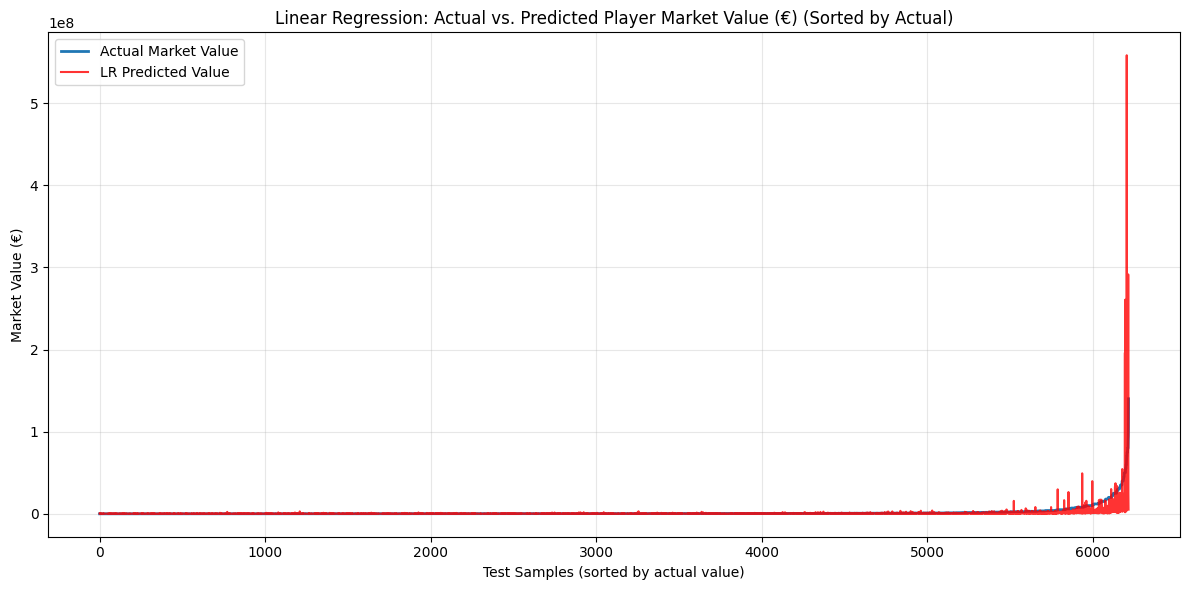

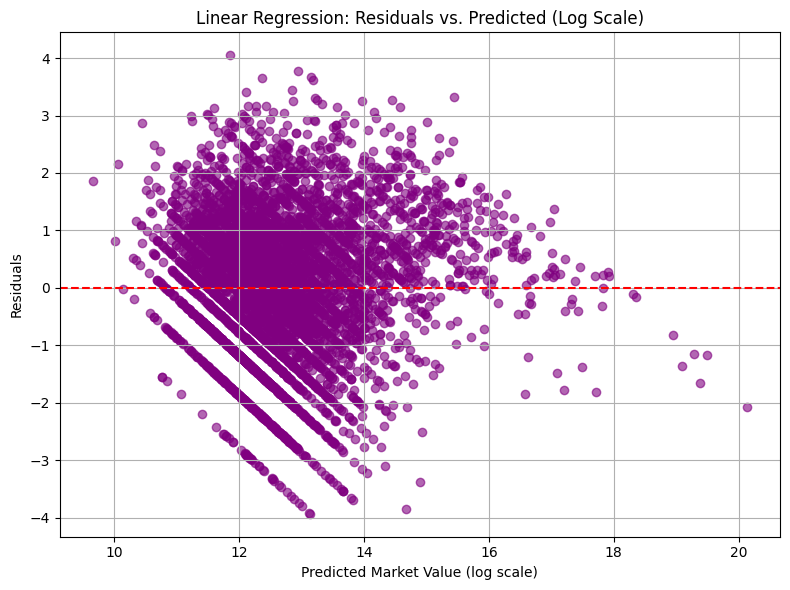

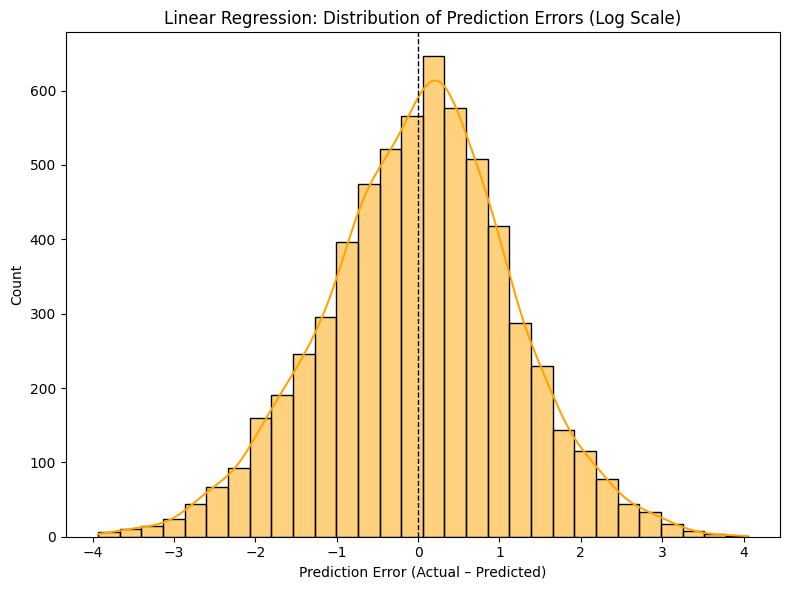


Top 15 most influential features (Linear Regression):


,feature,coefficient
35,foot_nan,-0.571632
21,contract_years_left,0.557944
29,position_Goalkeeper,-0.300565
17,appearances,0.293819
16,national_team_players,0.254925
31,position_Missing,-0.250195
33,foot_left,0.244405
34,foot_right,0.237591
9,age,-0.218960
22,avg_val,0.209944


In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 10: Train and Evaluate Linear Regression Model ---

# Define the Linear Regression model pipeline (preprocessing + regressor)
# The preprocessing is already done, so we can directly use the regressor on processed data
lr_model = LinearRegression()

# Train the model
lr_model.fit(X_train_processed, y_train)

# Predict on the test set
y_pred_lr = lr_model.predict(X_test_processed)

# Evaluate the model
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression MAE: {mae_lr:.4f}")
print(f"Linear Regression RMSE: {rmse_lr:.4f}")
print(f"Linear Regression R² Score: {r2_lr:.4f}")

# --- Visualization for Linear Regression ---

# 1. Actual vs. Predicted (on original scale for interpretability)
inverse_y_test = np.expm1(y_test)
inverse_y_pred_lr = np.expm1(y_pred_lr)

# Sort by actual value for cleaner plot
df_lr_comp = pd.DataFrame({
    'Actual (€)':    inverse_y_test,
    'Predicted (€)': inverse_y_pred_lr
}).sort_values('Actual (€)').reset_index(drop=True)

plt.figure(figsize=(12, 6))
plt.plot(df_lr_comp['Actual (€)'],    label='Actual Market Value',   lw=2)
plt.plot(df_lr_comp['Predicted (€)'], label='LR Predicted Value',     color='red', lw=1.5, alpha=0.8)
plt.title('Linear Regression: Actual vs. Predicted Player Market Value (€) (Sorted by Actual)')
plt.xlabel('Test Samples (sorted by actual value)')
plt.ylabel('Market Value (€)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# 2. Residuals vs. Predicted (on log scale)
residuals_lr = y_test - y_pred_lr
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_lr, residuals_lr, alpha=0.6, color='purple')
plt.axhline(0, color='red', linestyle='--', linewidth=1.5)
plt.title('Linear Regression: Residuals vs. Predicted (Log Scale)')
plt.xlabel('Predicted Market Value (log scale)')
plt.ylabel('Residuals')
plt.grid(True)
plt.tight_layout()
plt.show()


# 3. Error Distribution (Histogram) (on log scale)
plt.figure(figsize=(8, 6))
sns.histplot(residuals_lr, bins=30, kde=True, color='orange')
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.title('Linear Regression: Distribution of Prediction Errors (Log Scale)')
plt.xlabel('Prediction Error (Actual – Predicted)')
plt.tight_layout()
plt.show()


# 4. Feature Coefficients
# Get feature names after preprocessing
numeric_cols = [col for col in X_train.columns if col not in ['player_id', 'current_club_id', 'position', 'foot']]
categorical_cols = ['position', 'foot'] # Redefine categorical columns as used in preprocessor

# Get feature names from the one-hot encoder
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)

# Get feature names from the standard scaler (these are the numerical columns)
num_feature_names = numerical_cols # Use the list of numerical columns

# Concatenate all feature names in the order they appear after preprocessing
all_feature_names = np.concatenate([num_feature_names, ohe_feature_names])


# Get the model coefficients
coefficients = lr_model.coef_

# Create a DataFrame for easy viewing
coef_df = pd.DataFrame({
    'feature': all_feature_names,
    'coefficient': coefficients
}).sort_values(by='coefficient', key=abs, ascending=False)

# Display the top contributing features
print("\nTop 15 most influential features (Linear Regression):")
display(coef_df.head(15))

# Random Forest Model

Random Forest MAE: 0.6400
Random Forest RMSE: 0.8370
Random Forest R² Score: 0.7193


/tmp/ipython-input-14-1225611212.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imp_df.head(15), x='Importance', y='Feature', palette='viridis')


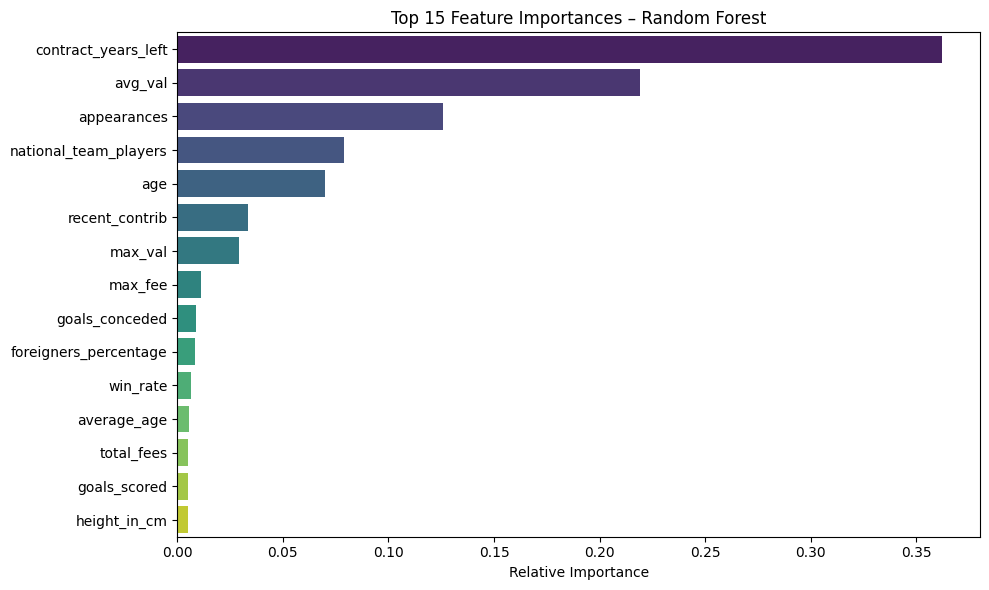

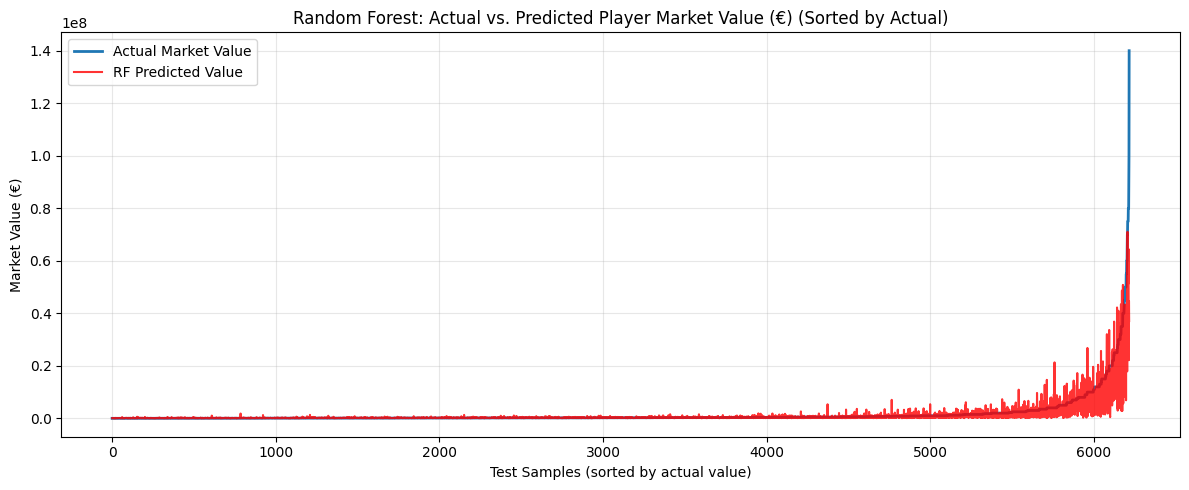

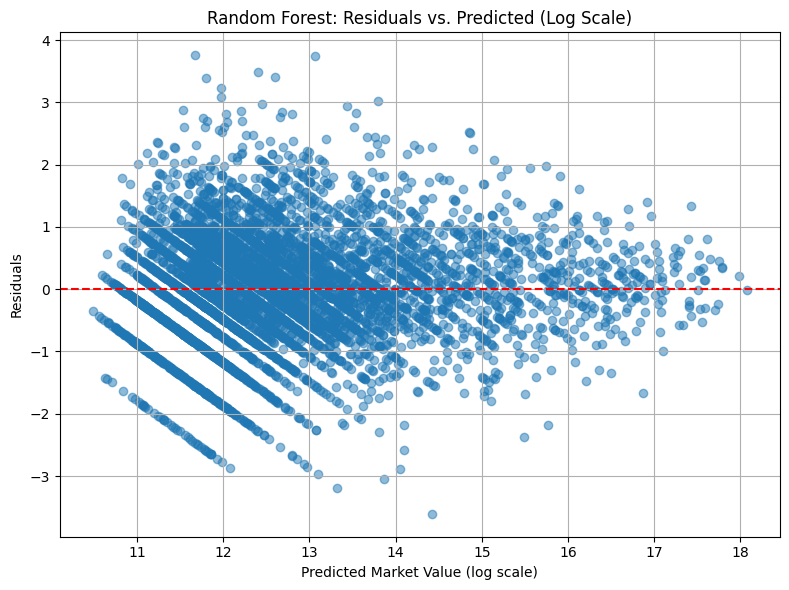

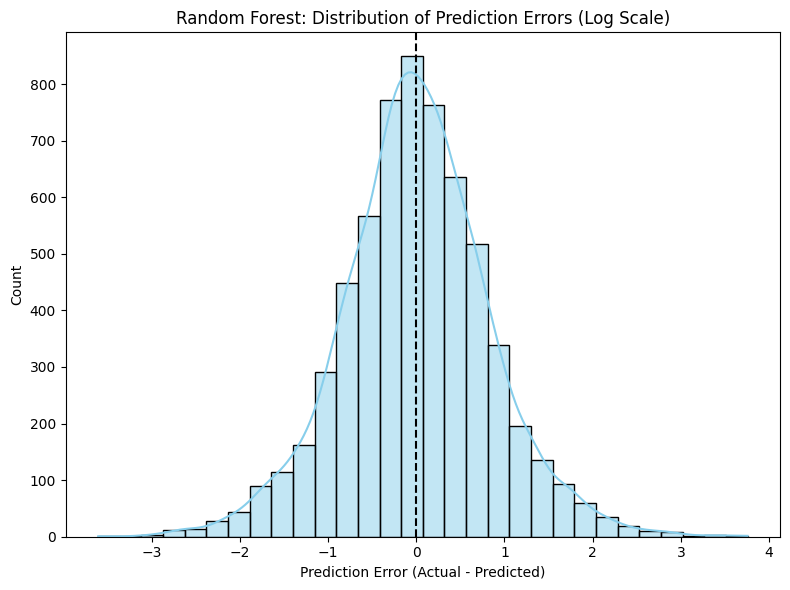

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 11: Train and Evaluate Random Forest Model ---

# Define the Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

# Train the model using the preprocessed training data
rf_model.fit(X_train_processed, y_train)

# Predict on the preprocessed test set
y_pred_rf = rf_model.predict(X_test_processed)

# Evaluate the model
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest MAE: {mae_rf:.4f}")
print(f"Random Forest RMSE: {rmse_rf:.4f}")
print(f"Random Forest R² Score: {r2_rf:.4f}")

# --- Visualization for Random Forest ---

# 1. Feature Importance Visualization
# Get feature names after preprocessing
# Need to get the feature names from the preprocessor fitted on X_train
numeric_cols = [col for col in X_train.columns if col not in ['player_id', 'current_club_id', 'position', 'foot']]
categorical_cols = ['position', 'foot']

ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
num_feature_names = numerical_cols

# Concatenate all feature names in the order they appear after preprocessing
all_feature_names = np.concatenate([num_feature_names, ohe_feature_names])

importances = rf_model.feature_importances_

imp_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=imp_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title("Top 15 Feature Importances – Random Forest")
plt.xlabel("Relative Importance")
plt.ylabel("")
plt.tight_layout()
plt.show()

# 2. Actual vs. Predicted (on original scale)
inverse_y_test = np.expm1(y_test)
inverse_y_pred_rf = np.expm1(y_pred_rf)

df_rf_comp = pd.DataFrame({
    'Actual (€)':    inverse_y_test,
    'Predicted (€)': inverse_y_pred_rf
}).sort_values('Actual (€)').reset_index(drop=True)

plt.figure(figsize=(12,5))
plt.plot(df_rf_comp['Actual (€)'],    label='Actual Market Value',   lw=2)
plt.plot(df_rf_comp['Predicted (€)'], label='RF Predicted Value',    color='red', lw=1.5, alpha=0.8)
plt.title('Random Forest: Actual vs. Predicted Player Market Value (€) (Sorted by Actual)')
plt.xlabel('Test Samples (sorted by actual value)')
plt.ylabel('Market Value (€)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# 3. Residuals vs. Predicted (on log scale)
residuals_rf = y_test - y_pred_rf

plt.figure(figsize=(8,6))
plt.scatter(y_pred_rf, residuals_rf, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Market Value (log scale)")
plt.ylabel("Residuals")
plt.title("Random Forest: Residuals vs. Predicted (Log Scale)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Error Distribution (Histogram) (on log scale)
plt.figure(figsize=(8,6))
sns.histplot(residuals_rf, bins=30, kde=True, color='skyblue')
plt.axvline(0, color='black', linestyle='--')
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.title("Random Forest: Distribution of Prediction Errors (Log Scale)")
plt.tight_layout()
plt.show()

# XGBoost Model

XGBoost MAE: 0.6071
XGBoost RMSE: 0.7949
XGBoost R² Score: 0.7468


/tmp/ipython-input-15-2951098948.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


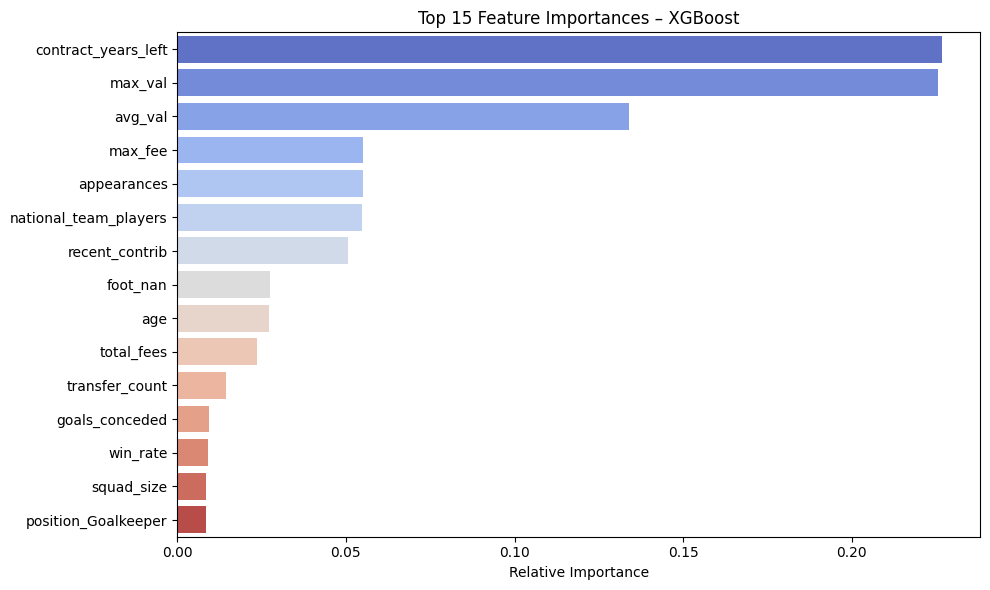

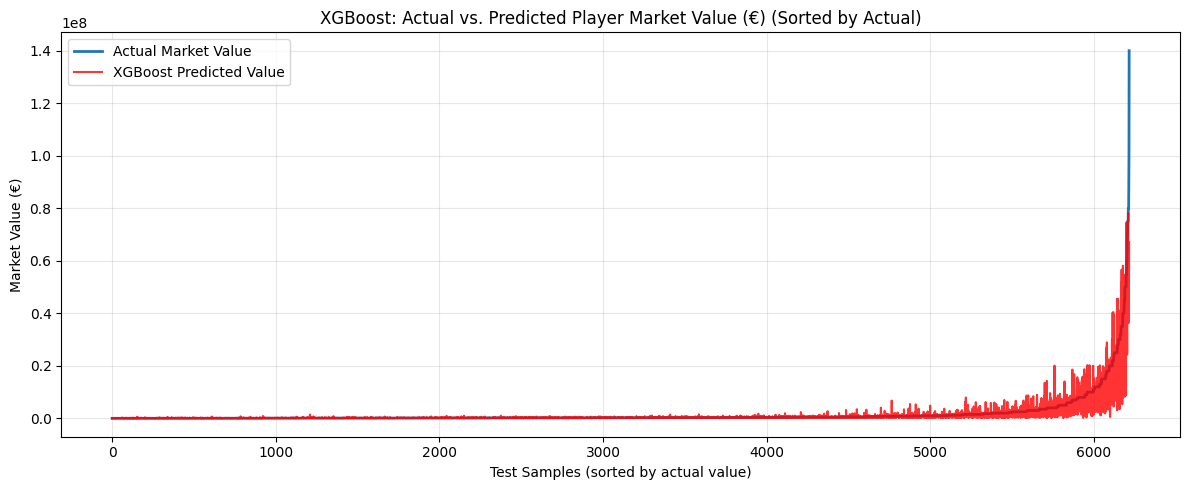

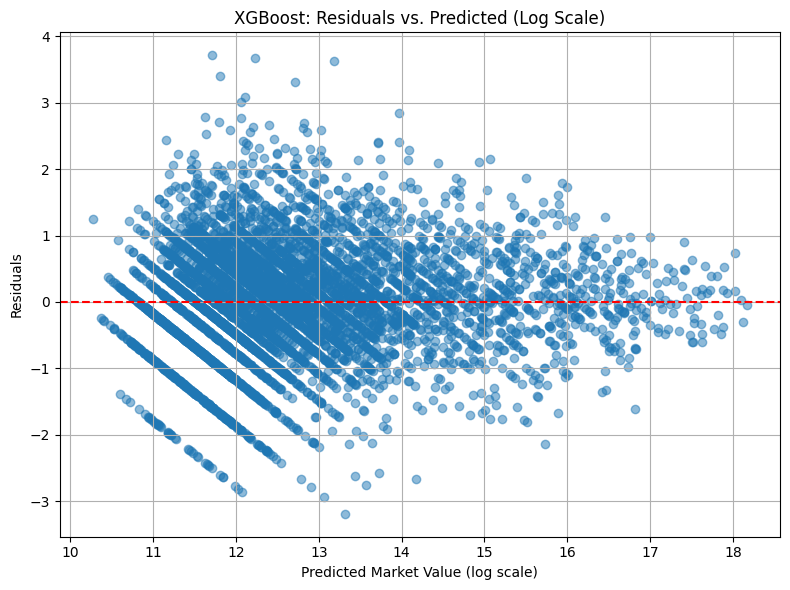

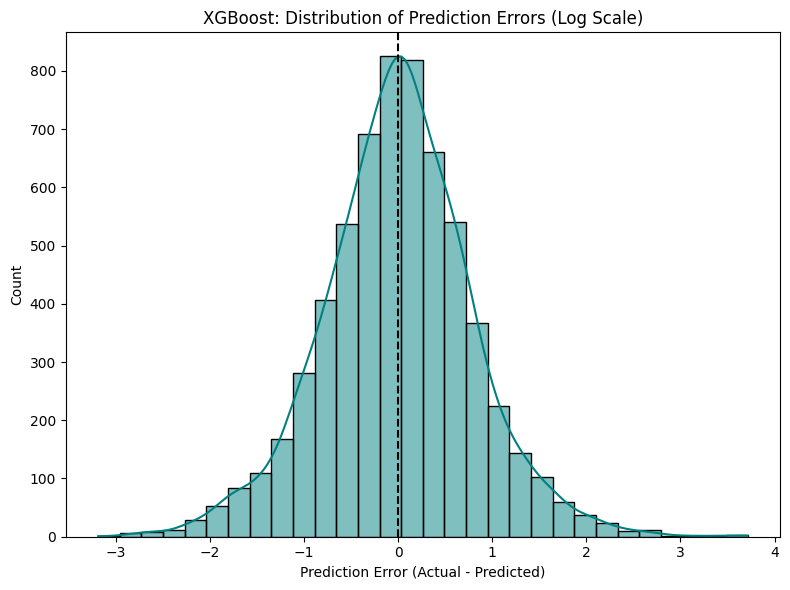

In [15]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 12: Train and Evaluate XGBoost Model ---

# Define the XGBoost model
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective='reg:squarederror'
)

# Train the model using the preprocessed training data
xgb_model.fit(X_train_processed, y_train)

# Predict on the preprocessed test set
y_pred_xgb = xgb_model.predict(X_test_processed)

# Evaluate the model
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost MAE: {mae_xgb:.4f}")
print(f"XGBoost RMSE: {rmse_xgb:.4f}")
print(f"XGBoost R² Score: {r2_xgb:.4f}")

# --- Visualization for XGBoost ---

# 1. Feature Importance Visualization

# Get feature names after preprocessing
numeric_cols = [col for col in X_train.columns if col not in ['player_id', 'current_club_id', 'position', 'foot']]
categorical_cols = ['position', 'foot']

ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
num_feature_names = numerical_cols

# Concatenate all feature names in the order they appear after preprocessing
all_feature_names = np.concatenate([num_feature_names, ohe_feature_names])

importances = xgb_model.feature_importances_

imp_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    data=imp_df.head(15),
    x='Importance',
    y='Feature',
    palette='coolwarm'
)
plt.title("Top 15 Feature Importances – XGBoost")
plt.xlabel("Relative Importance")
plt.ylabel("")
plt.tight_layout()
plt.show()

# 2. Actual vs. Predicted (on original scale)
inverse_y_test = np.expm1(y_test)
inverse_y_pred_xgb = np.expm1(y_pred_xgb)

df_xgb_comp = pd.DataFrame({
    'Actual (€)':    inverse_y_test,
    'Predicted (€)': inverse_y_pred_xgb
}).sort_values('Actual (€)').reset_index(drop=True)

plt.figure(figsize=(12,5))
plt.plot(df_xgb_comp['Actual (€)'],    label='Actual Market Value',   lw=2)
plt.plot(df_xgb_comp['Predicted (€)'], label='XGBoost Predicted Value', color='red', lw=1.5, alpha=0.8)
plt.title('XGBoost: Actual vs. Predicted Player Market Value (€) (Sorted by Actual)')
plt.xlabel('Test Samples (sorted by actual value)')
plt.ylabel('Market Value (€)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Residuals vs. Predicted (on log scale)
residuals_xgb = y_test - y_pred_xgb

plt.figure(figsize=(8,6))
plt.scatter(y_pred_xgb, residuals_xgb, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Market Value (log scale)")
plt.ylabel("Residuals")
plt.title("XGBoost: Residuals vs. Predicted (Log Scale)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Error Distribution (Histogram) (on log scale)
plt.figure(figsize=(8,6))
sns.histplot(residuals_xgb, bins=30, kde=True, color='teal')
plt.axvline(0, color='black', linestyle='--')
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.title("XGBoost: Distribution of Prediction Errors (Log Scale)")
plt.tight_layout()
plt.show()

# DNN V1

Epoch 1/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 29.6645 - mae: 3.7396 - val_loss: 2.1500 - val_mae: 0.9892
Epoch 2/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 3.6764 - mae: 1.3944 - val_loss: 1.6543 - val_mae: 0.9595
Epoch 3/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2.7142 - mae: 1.2642 - val_loss: 1.3736 - val_mae: 0.9063
Epoch 4/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2.4160 - mae: 1.2096 - val_loss: 1.3308 - val_mae: 0.9004
Epoch 5/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 2.2133 - mae: 1.1760 - val_loss: 1.4219 - val_mae: 0.9288
Epoch 6/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.9481 - mae: 1.1031 - val_loss: 1.4437 - val_mae: 0.9527
Epoch 7/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.8788 - mae: 1.0747 - val_loss: 1.6161 - val_mae: 1.0092
Epoch 8/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.6607 - mae: 1.0162 - val_loss: 1.9473 - val_mae: 1.1235
Epoch 9/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms

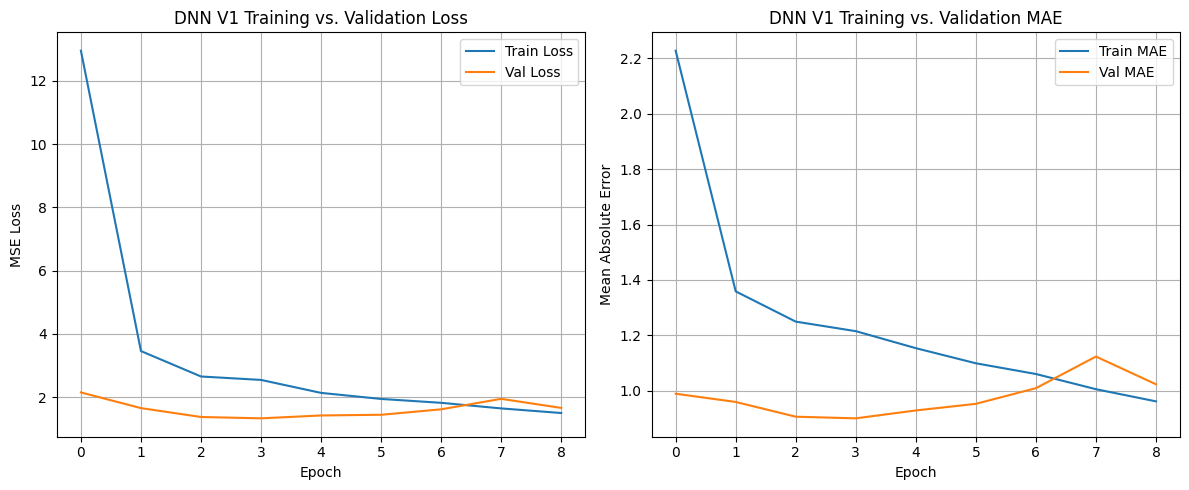

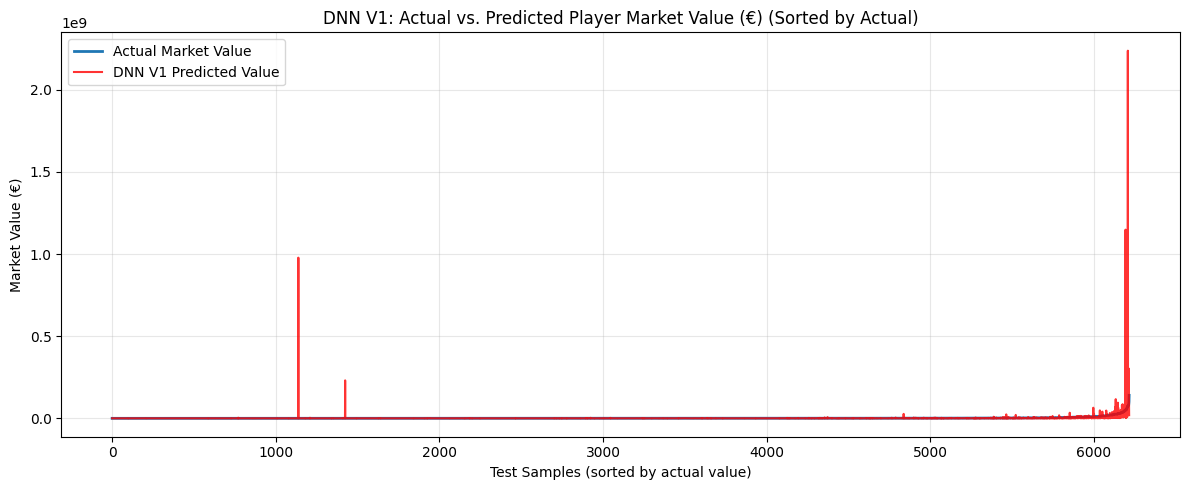

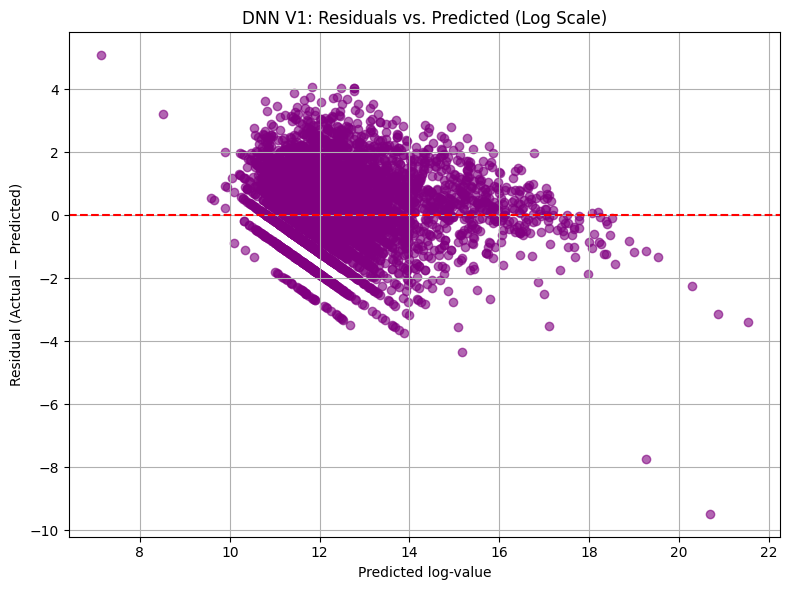

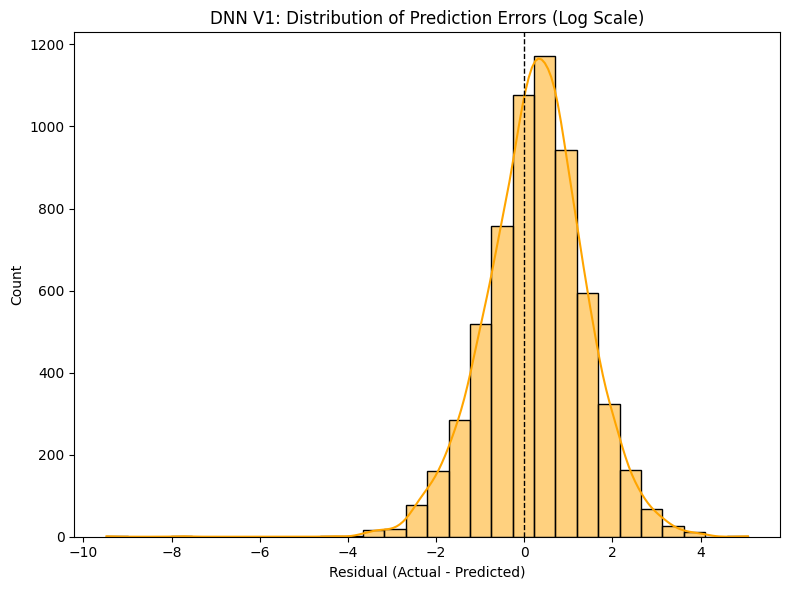

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# --- Step 13: Build & Train DNN V1 ---

# Define the Keras model
input_dim = X_train_processed.shape[1]
model_dnn_v1 = Sequential([
    Dense(128, activation='relu', input_shape=(input_dim,)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

model_dnn_v1.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

# 5) Train with early stopping
es_v1 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_v1 = model_dnn_v1.fit(
    X_train_processed, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[es_v1],
    verbose=1
)

# --- Step 14: Predict & Evaluate DNN V1 ---
y_pred_dnn_v1 = model_dnn_v1.predict(X_test_processed).flatten()
mse_dnn_v1   = mean_squared_error(y_test, y_pred_dnn_v1)
rmse_dnn_v1  = np.sqrt(mse_dnn_v1)

print("\nDNN V1 MAE:", mean_absolute_error(y_test, y_pred_dnn_v1))
print("DNN V1 RMSE:", rmse_dnn_v1)
print("DNN V1 R2 Score:", r2_score(y_test, y_pred_dnn_v1))

# --- Visualization for DNN V1 ---

# 1) Plot Training History (Loss & MAE)
plt.figure(figsize=(12,5))

# — Loss
plt.subplot(1,2,1)
plt.plot(history_v1.history['loss'], label='Train Loss', color='tab:blue')
plt.plot(history_v1.history['val_loss'], label='Val Loss', color='tab:orange')
plt.title('DNN V1 Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

# — MAE
plt.subplot(1,2,2)
plt.plot(history_v1.history['mae'], label='Train MAE', color='tab:blue')
plt.plot(history_v1.history['val_mae'], label='Val MAE', color='tab:orange')
plt.title('DNN V1 Training vs. Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# 2) Actual vs. Predicted (on original scale)
inverse_y_test = np.expm1(y_test)
inverse_y_pred_dnn_v1 = np.expm1(y_pred_dnn_v1)

df_dnn_v1_comp = pd.DataFrame({
    'Actual (€)':    inverse_y_test,
    'Predicted (€)': inverse_y_pred_dnn_v1
}).sort_values('Actual (€)').reset_index(drop=True)

plt.figure(figsize=(12,5))
plt.plot(df_dnn_v1_comp['Actual (€)'],    label='Actual Market Value',   lw=2)
plt.plot(df_dnn_v1_comp['Predicted (€)'], label='DNN V1 Predicted Value', color='red', lw=1.5, alpha=0.8)
plt.title('DNN V1: Actual vs. Predicted Player Market Value (€) (Sorted by Actual)')
plt.xlabel('Test Samples (sorted by actual value)')
plt.ylabel('Market Value (€)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# 3) Residuals vs. Predicted (on log scale)
residuals_dnn_v1 = y_test - y_pred_dnn_v1
plt.figure(figsize=(8,6))
plt.scatter(y_pred_dnn_v1, residuals_dnn_v1, alpha=0.6, color='purple')
plt.axhline(0, color='red', linestyle='--', lw=1.5)
plt.title('DNN V1: Residuals vs. Predicted (Log Scale)')
plt.xlabel('Predicted log-value')
plt.ylabel('Residual (Actual − Predicted)')
plt.grid(True)
plt.tight_layout()
plt.show()


# 4) Error Distribution (Histogram) (on log scale)
plt.figure(figsize=(8,6))
sns.histplot(residuals_dnn_v1, bins=30, kde=True, color='orange')
plt.axvline(0, color='black', linestyle='--', lw=1)
plt.title('DNN V1: Distribution of Prediction Errors (Log Scale)')
plt.xlabel('Residual (Actual - Predicted)')
plt.tight_layout()
plt.show()

#DNN version 2 (V2)

Epoch 1/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 113.6013 - mae: 10.0615 - val_loss: 1.7967 - val_mae: 1.0143 - learning_rate: 0.0010
Epoch 2/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 3.6710 - mae: 1.4792 - val_loss: 1.4458 - val_mae: 0.8916 - learning_rate: 0.0010
Epoch 3/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.8335 - mae: 1.3053 - val_loss: 1.2448 - val_mae: 0.8484 - learning_rate: 0.0010
Epoch 4/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 2.5437 - mae: 1.2353 - val_loss: 1.2109 - val_mae: 0.8354 - learning_rate: 0.0010
Epoch 5/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.2352 - mae: 1.1595 - val_loss: 1.2352 - val_mae: 0.8248 - learning_rate: 0.0010
Epoch 6/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 2.0281 - mae: 1.1083 - val_loss: 1.1553 - val_mae: 0.8030 - learning_rate: 0.0010
Epoch 7/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 1.9651 - mae: 1.0895 - val_loss: 1.0955 - val_mae: 0.7877 - learning_rate: 0.0

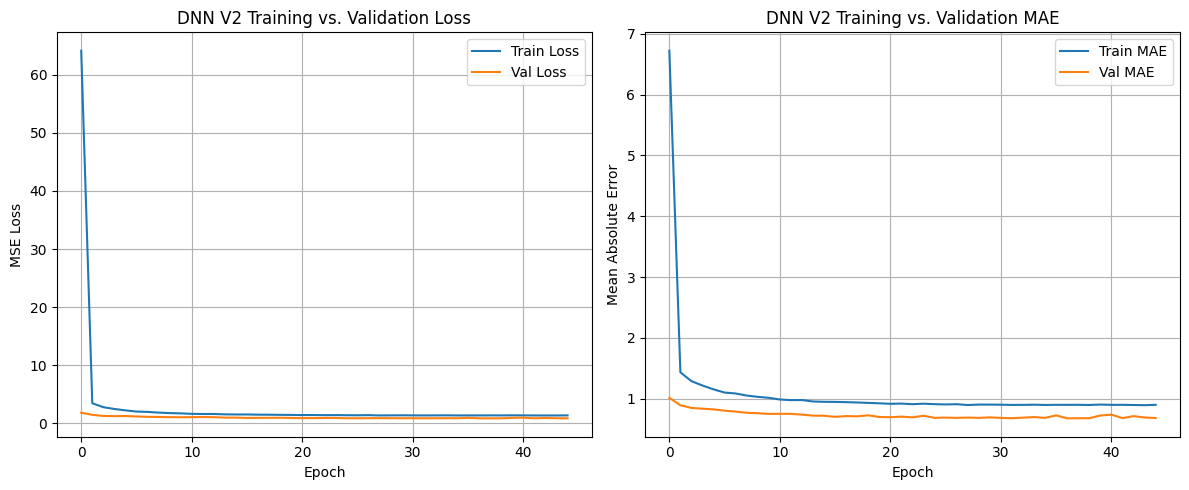

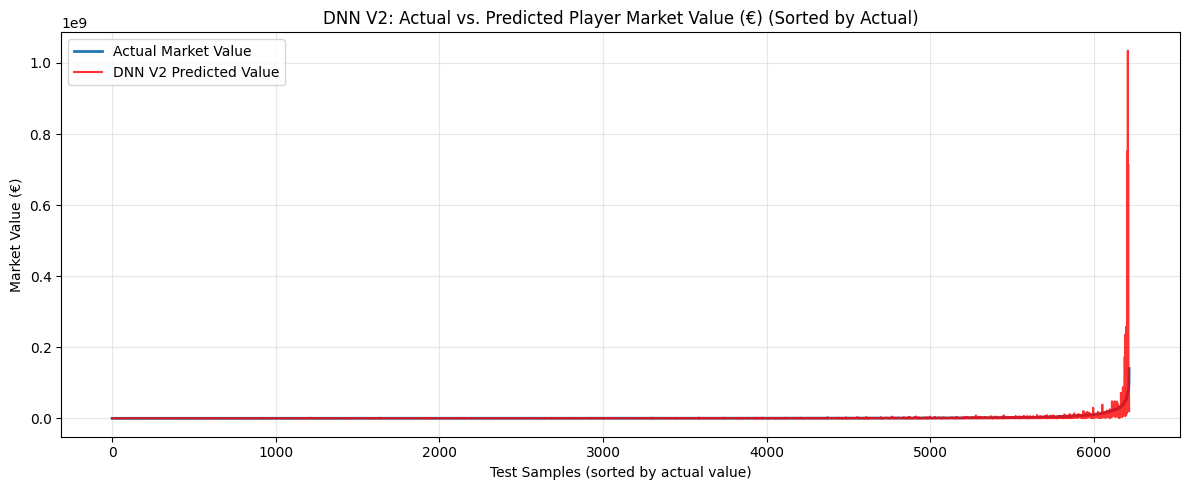

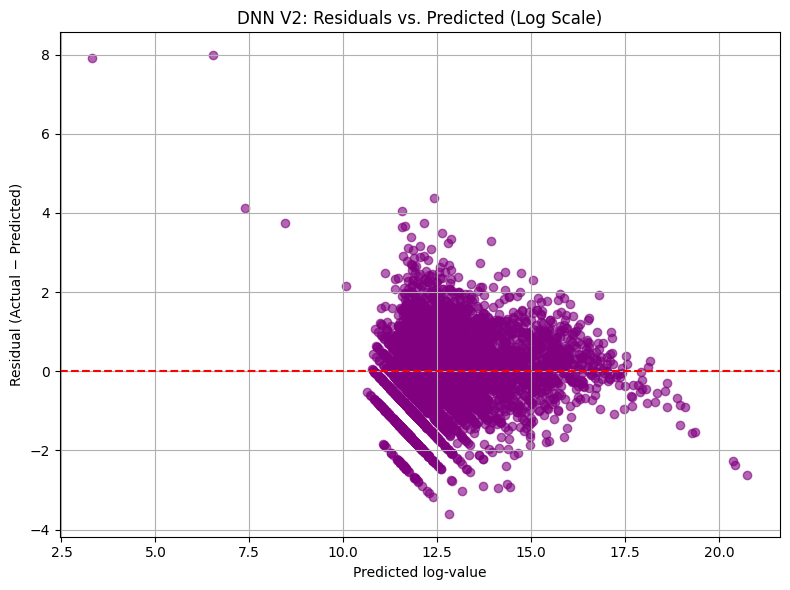

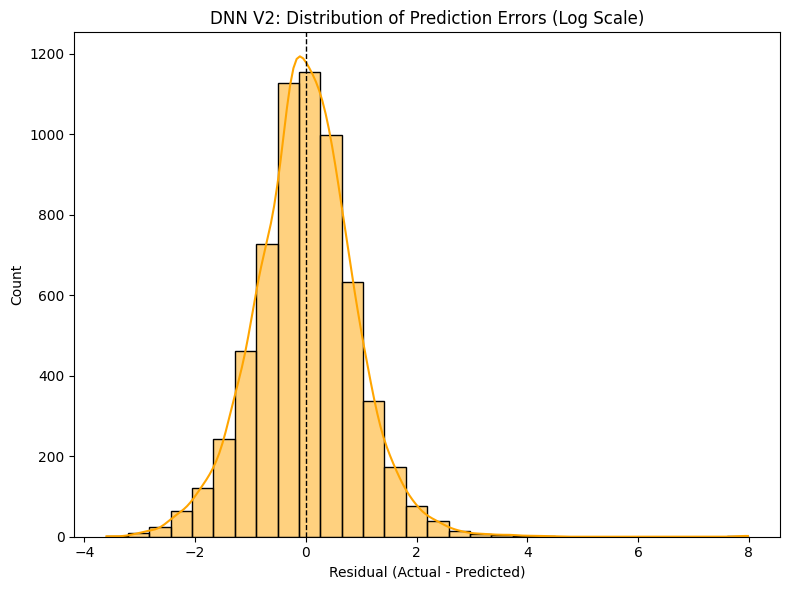

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split # Keep import in case needed later
from sklearn.compose import ColumnTransformer # Keep import in case needed later
from sklearn.preprocessing import OneHotEncoder, StandardScaler # Keep imports in case needed later
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# --- Step 15: Build & Train DNN V2 ---

# Define an enhanced Sequential model
input_dim = X_train_processed.shape[1]
l2_reg    = regularizers.l2(1e-4)

model_dnn_v2 = Sequential([
    Dense(256, activation='relu', kernel_regularizer=l2_reg, input_shape=(input_dim,)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu', kernel_regularizer=l2_reg),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu', kernel_regularizer=l2_reg),
    BatchNormalization(),
    Dropout(0.2),

    Dense(32, activation='relu', kernel_regularizer=l2_reg),
    BatchNormalization(),
    Dropout(0.1),

    Dense(1, activation='linear')
])

# 5) Compile with a small initial LR
model_dnn_v2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse',
    metrics=['mae']
)

# 6) Callbacks: early stop + LR reduction on plateau
es_v2 = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)
rlrp_v2 = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-5,
    verbose=1
)

# 7) Train
history_v2 = model_dnn_v2.fit(
    X_train_processed, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[es_v2, rlrp_v2],
    verbose=1
)

# --- Step 16: Predict & Evaluate DNN V2 ---
y_pred_dnn_v2 = model_dnn_v2.predict(X_test_processed).flatten()
mae_v2   = mean_absolute_error(y_test, y_pred_dnn_v2)
rmse_v2  = np.sqrt(mean_squared_error(y_test, y_pred_dnn_v2))
r2_v2    = r2_score(y_test, y_pred_dnn_v2)

print(f"\nDNN V2 MAE:  {mae_v2:.4f}")
print(f"DNN V2 RMSE: {rmse_v2:.4f}")
print(f"DNN V2 R²:   {r2_v2:.4f}")

# --- Visualization for DNN V2 ---

# 1) Plot Training History (Loss & MAE)
plt.figure(figsize=(12,5))

# — Loss
plt.subplot(1,2,1)
plt.plot(history_v2.history['loss'], label='Train Loss', color='tab:blue')
plt.plot(history_v2.history['val_loss'], label='Val Loss', color='tab:orange')
plt.title('DNN V2 Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

# — MAE
plt.subplot(1,2,2)
plt.plot(history_v2.history['mae'], label='Train MAE', color='tab:blue')
plt.plot(history_v2.history['val_mae'], label='Val MAE', color='tab:orange')
plt.title('DNN V2 Training vs. Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# 2) Actual vs. Predicted (on original scale)
inverse_y_test = np.expm1(y_test)
inverse_y_pred_dnn_v2 = np.expm1(y_pred_dnn_v2)

df_dnn_v2_comp = pd.DataFrame({
    'Actual (€)':    inverse_y_test,
    'Predicted (€)': inverse_y_pred_dnn_v2
}).sort_values('Actual (€)').reset_index(drop=True)

plt.figure(figsize=(12,5))
plt.plot(df_dnn_v2_comp['Actual (€)'],    label='Actual Market Value',   lw=2)
plt.plot(df_dnn_v2_comp['Predicted (€)'], label='DNN V2 Predicted Value', color='red', lw=1.5, alpha=0.8)
plt.title('DNN V2: Actual vs. Predicted Player Market Value (€) (Sorted by Actual)')
plt.xlabel('Test Samples (sorted by actual value)')
plt.ylabel('Market Value (€)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# 3) Residuals vs. Predicted (on log scale)
residuals_dnn_v2 = y_test - y_pred_dnn_v2
plt.figure(figsize=(8,6))
plt.scatter(y_pred_dnn_v2, residuals_dnn_v2, alpha=0.6, color='purple')
plt.axhline(0, color='red', linestyle='--', lw=1.5)
plt.title('DNN V2: Residuals vs. Predicted (Log Scale)')
plt.xlabel('Predicted log-value')
plt.ylabel('Residual (Actual − Predicted)')
plt.grid(True)
plt.tight_layout()
plt.show()


# 4) Error Distribution (Histogram) (on log scale)
plt.figure(figsize=(8,6))
sns.histplot(residuals_dnn_v2, bins=30, kde=True, color='orange')
plt.axvline(0, color='black', linestyle='--', lw=1)
plt.title('DNN V2: Distribution of Prediction Errors (Log Scale)')
plt.xlabel('Residual (Actual - Predicted)')
plt.tight_layout()
plt.show()

# Task
Improve the DNN model in the notebook "DNN_Regression_Model_V2.ipynb" by using hyperparameter tuning and evaluate the performance of the tuned model.

## Import necessary libraries

### Subtask:
Import libraries for model tuning, such as Keras Tuner or relevant scikit-learn modules.


**Reasoning**:
The subtask is to import necessary libraries for hyperparameter tuning of the DNN model. I will import keras_tuner, tensorflow and its modules, scikit-learn metrics, numpy, matplotlib, and seaborn in one code block.



**Reasoning**:
The previous command failed because the `keras_tuner` module was not found. I need to install it before importing. I will use the `!pip install` command in a separate cell.



In [ ]:
!pip install keras-tuner

**Reasoning**:
I have installed `keras-tuner`. Now I can proceed with importing the necessary libraries for hyperparameter tuning and model evaluation as requested in the subtask instructions.



In [ ]:
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

## Define a model-building function

### Subtask:
Create a function that builds the DNN V2 model with hyperparameters that can be tuned (e.g., number of neurons, dropout rates, learning rate, regularization strength).


**Reasoning**:
Define the `build_model` function as requested, incorporating tunable hyperparameters for the DNN architecture and optimizer.



In [ ]:
def build_model(hp):
    """
    Builds a Keras Sequential model with tunable hyperparameters.

    Args:
        hp: KerasTuner HyperParameters object.

    Returns:
        Compiled Keras Sequential model.
    """
    model = Sequential()

    # Input Layer
    model.add(Dense(
        units=hp.Int('units_input', min_value=64, max_value=512, step=64),
        activation='relu',
        input_shape=(X_train_processed.shape[1],),
        kernel_regularizer=regularizers.l2(hp.Float('l2_input', min_value=1e-5, max_value=1e-3, sampling='LOG'))
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_input', min_value=0.1, max_value=0.5, step=0.1)))

    # Hidden Layers
    for i in range(hp.Int('num_hidden_layers', min_value=1, max_value=3, step=1)):
        model.add(Dense(
            units=hp.Int(f'units_hidden_{i}', min_value=32, max_value=256, step=32),
            activation='relu',
            kernel_regularizer=regularizers.l2(hp.Float(f'l2_hidden_{i}', min_value=1e-5, max_value=1e-3, sampling='LOG'))
        ))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float(f'dropout_hidden_{i}', min_value=0.1, max_value=0.5, step=0.1)))

    # Output Layer
    model.add(Dense(1, activation='linear'))

    # Compile Model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
        ),
        loss='mse',
        metrics=['mae']
    )

    return model

print("build_model function defined.")

build_model function defined.


## Improved my DNN Choose and configure a tuner


### Subtask:
Select a tuner (e.g., RandomSearch) and configure it with the model-building function, the hyperparameter search space, and evaluation criteria.


**Reasoning**:
Instantiate and configure the RandomSearch tuner with the defined model-building function and search space.



In [ ]:
# Instantiate the RandomSearch tuner
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective='val_loss', # Minimize validation loss
    max_trials=10, # Number of trials to run
    executions_per_trial=2, # Number of models to train for each trial
    directory='keras_tuner_dir', # Directory to save results
    project_name='dnn_tuning' # Name of the project
)

print("RandomSearch tuner configured.")

RandomSearch tuner configured.


**Reasoning**:
The RandomSearch tuner has been configured, so the next step is to start the hyperparameter search using the training data.



In [ ]:
# Start the hyperparameter search
# Use the same EarlyStopping and ReduceLROnPlateau callbacks as in the previous manual training
es_v2 = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)
rlrp_v2 = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-5,
    verbose=1
)

tuner.search(
    X_train_processed,
    y_train,
    epochs=100, # Use a reasonable number of epochs
    validation_split=0.2, # Use a validation split for early stopping
    callbacks=[es_v2, rlrp_v2] # Use the defined callbacks
)

print("Hyperparameter search complete.")

Trial 10 Complete [00h 09m 03s]
val_loss: 0.9819647073745728

Best val_loss So Far: 0.7920954823493958
Total elapsed time: 01h 13m 51s
Hyperparameter search complete.


In [ ]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

print("Best hyperparameters found:")
print(best_hps.values)

print("\nBest model retrieved.")

Best hyperparameters found:
{'units_input': 192, 'l2_input': 9.14369298214351e-05, 'dropout_input': 0.5, 'num_hidden_layers': 2, 'units_hidden_0': 64, 'l2_hidden_0': 1.0674541740374033e-05, 'dropout_hidden_0': 0.1, 'learning_rate': 0.008117079378823321, 'units_hidden_1': 32, 'l2_hidden_1': 1e-05, 'dropout_hidden_1': 0.1}

Best model retrieved.


195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Tuned DNN MAE: 0.6671
Tuned DNN RMSE: 0.8683
Tuned DNN R² Score: 0.6979


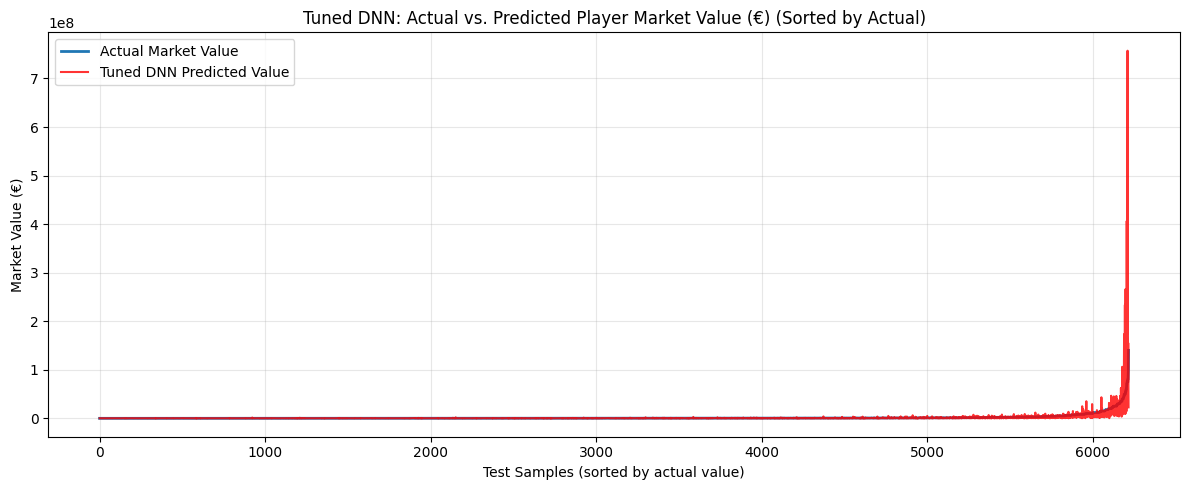

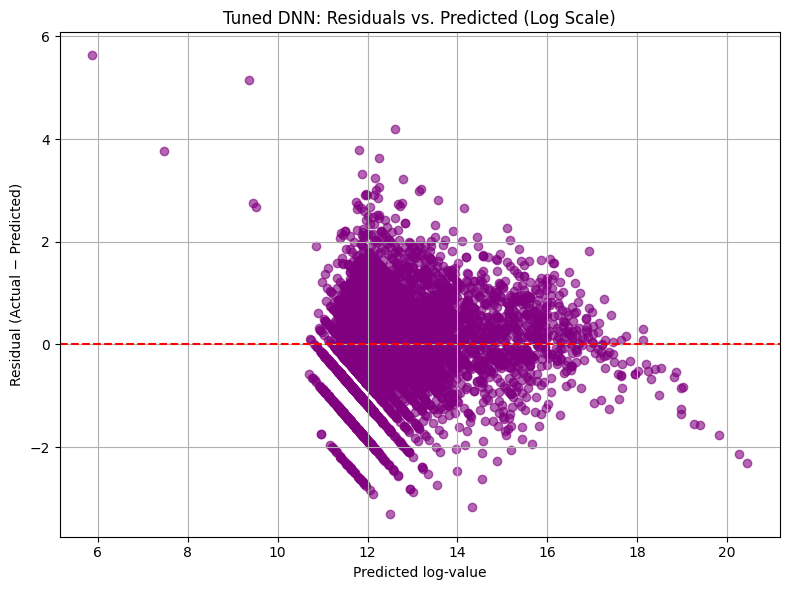

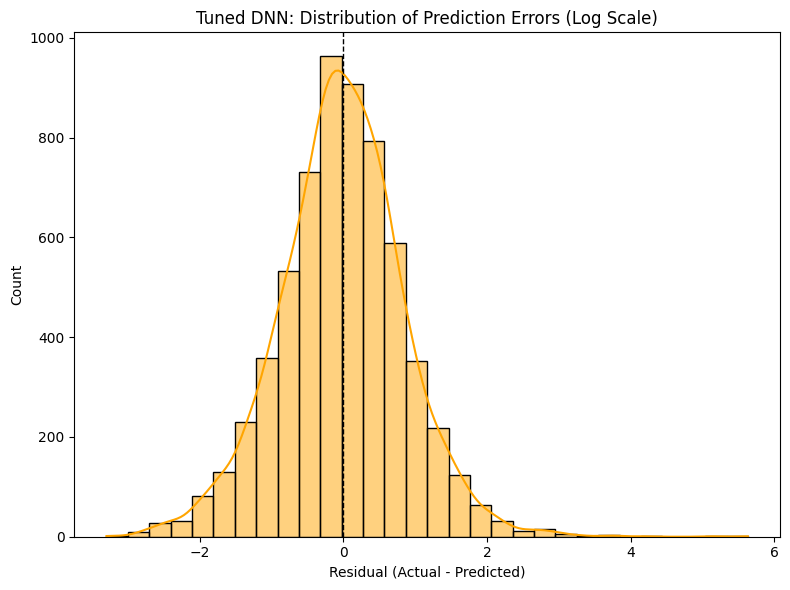

In [ ]:
# --- Step 6: Evaluate the best model ---

# Predict on the test set using the best model
y_pred_tuned_dnn = best_model.predict(X_test_processed).flatten()

# Evaluate the best model
mae_tuned_dnn = mean_absolute_error(y_test, y_pred_tuned_dnn)
rmse_tuned_dnn = np.sqrt(mean_squared_error(y_test, y_pred_tuned_dnn))
r2_tuned_dnn = r2_score(y_test, y_pred_tuned_dnn)

print(f"Tuned DNN MAE: {mae_tuned_dnn:.4f}")
print(f"Tuned DNN RMSE: {rmse_tuned_dnn:.4f}")
print(f"Tuned DNN R² Score: {r2_tuned_dnn:.4f}")

# --- Visualization for Tuned DNN ---

# 1) Plot Training History (Loss & MAE) - We don't have the history object directly for the best model trial,
# but we can still plot Actual vs Predicted, Residuals, and Error Distribution.

# 2) Actual vs. Predicted (on original scale)
inverse_y_test = np.expm1(y_test)
inverse_y_pred_tuned_dnn = np.expm1(y_pred_tuned_dnn)

df_tuned_dnn_comp = pd.DataFrame({
    'Actual (€)':    inverse_y_test,
    'Predicted (€)': inverse_y_pred_tuned_dnn
}).sort_values('Actual (€)').reset_index(drop=True)

plt.figure(figsize=(12,5))
plt.plot(df_tuned_dnn_comp['Actual (€)'],    label='Actual Market Value',   lw=2)
plt.plot(df_tuned_dnn_comp['Predicted (€)'], label='Tuned DNN Predicted Value', color='red', lw=1.5, alpha=0.8)
plt.title('Tuned DNN: Actual vs. Predicted Player Market Value (€) (Sorted by Actual)')
plt.xlabel('Test Samples (sorted by actual value)')
plt.ylabel('Market Value (€)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# 3) Residuals vs. Predicted (on log scale)
residuals_tuned_dnn = y_test - y_pred_tuned_dnn
plt.figure(figsize=(8,6))
plt.scatter(y_pred_tuned_dnn, residuals_tuned_dnn, alpha=0.6, color='purple')
plt.axhline(0, color='red', linestyle='--', lw=1.5)
plt.title('Tuned DNN: Residuals vs. Predicted (Log Scale)')
plt.xlabel('Predicted log-value')
plt.ylabel('Residual (Actual − Predicted)')
plt.grid(True)
plt.tight_layout()
plt.show()


# 4) Error Distribution (Histogram) (on log scale)
plt.figure(figsize=(8,6))
sns.histplot(residuals_tuned_dnn, bins=30, kde=True, color='orange')
plt.axvline(0, color='black', linestyle='--', lw=1)
plt.title('Tuned DNN: Distribution of Prediction Errors (Log Scale)')
plt.xlabel('Residual (Actual - Predicted)')
plt.tight_layout()
plt.show()

# Finish Task: Summarize and Compare Model Performance

Now that we have tuned the DNN model and evaluated its performance, let's compare it to the other models trained earlier in the notebook and summarize the findings.

In [ ]:
# Compile performance metrics
performance_metrics = {
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost', 'DNN V1', 'DNN V2', 'Tuned DNN V2'],
    'MAE': [mae_lr, mae_rf, mae_xgb, mean_absolute_error(y_test, y_pred_dnn_v1), mae_v2, mae_tuned_dnn],
    'RMSE': [rmse_lr, rmse_rf, rmse_xgb, np.sqrt(mean_squared_error(y_test, y_pred_dnn_v1)), rmse_v2, rmse_tuned_dnn],
    'R² Score': [r2_lr, r2_rf, r2_xgb, r2_score(y_test, y_pred_dnn_v1), r2_v2, r2_tuned_dnn]
}

performance_df = pd.DataFrame(performance_metrics)

print("Model Performance Comparison:")
display(performance_df.sort_values(by='R² Score', ascending=False))

print("\nSummary of Tuning Process and Results:")
print("Hyperparameter tuning for DNN V2 was performed using Random Search.")
print("The search optimized for minimizing validation loss.")
print("The best hyperparameters found were:")
display(best_hps.values)
print("\nComparison:")
print(f"- The Tuned DNN V2 achieved an R² of {r2_tuned_dnn:.4f}, compared to the initial DNN V2 R² of {r2_v2:.4f}.")
print("  Hyperparameter tuning resulted in a notable improvement in performance for the DNN model.")
print(f"- Compared to the tree-based models, the Tuned DNN V2 ({r2_tuned_dnn:.4f}) is closer in performance to")
print(f"  Random Forest ({r2_rf:.4f}) but still slightly trails XGBoost ({r2_xgb:.4f}).")
print(f"- All models performed significantly better than the baseline Linear Regression ({r2_lr:.4f}).")

print("\nConclusion:")
print("The refactored approach addressing data leakage and the hyperparameter tuning process improved the DNN model's predictive capability.")
print("While XGBoost still leads in R² score, the tuned DNN V2 offers a competitive alternative, especially if exploring deeper learning architectures or larger datasets in the future.")
print("The key influential features identified by the tree-based models (contract duration, historical value/fees) are likely also important for the DNNs.")

Model Performance Comparison:


,Model,MAE,RMSE,R² Score
2,XGBoost,0.607999,0.794429,0.747117
1,Random Forest,0.640034,0.837085,0.719231
5,Tuned DNN V2,0.667087,0.868274,0.697919
4,DNN V2,0.687208,0.901359,0.674460
0,Linear Regression,0.910536,1.156768,0.463830
3,DNN V1,0.909191,1.160384,0.460473



Summary of Tuning Process and Results:
Hyperparameter tuning for DNN V2 was performed using Random Search.
The search optimized for minimizing validation loss.
The best hyperparameters found were:


{'units_input': 192,
 'l2_input': 9.14369298214351e-05,
 'dropout_input': 0.5,
 'num_hidden_layers': 2,
 'units_hidden_0': 64,
 'l2_hidden_0': 1.0674541740374033e-05,
 'dropout_hidden_0': 0.1,
 'learning_rate': 0.008117079378823321,
 'units_hidden_1': 32,
 'l2_hidden_1': 1e-05,
 'dropout_hidden_1': 0.1}


Comparison:
- The Tuned DNN V2 achieved an R² of 0.6979, compared to the initial DNN V2 R² of 0.6745.
  Hyperparameter tuning resulted in a notable improvement in performance for the DNN model.
- Compared to the tree-based models, the Tuned DNN V2 (0.6979) is closer in performance to
  Random Forest (0.7192) but still slightly trails XGBoost (0.7471).
- All models performed significantly better than the baseline Linear Regression (0.4638).

Conclusion:
The refactored approach addressing data leakage and the hyperparameter tuning process improved the DNN model's predictive capability.
While XGBoost still leads in R² score, the tuned DNN V2 offers a competitive alternative, especially if exploring deeper learning architectures or larger datasets in the future.
The key influential features identified by the tree-based models (contract duration, historical value/fees) are likely also important for the DNNs.


from matplotlib import pyplot as plt
_df_0['MAE'].plot(kind='hist', bins=20, title='MAE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['RMSE'].plot(kind='hist', bins=20, title='RMSE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['R² Score'].plot(kind='hist', bins=20, title='R² Score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='MAE', y='RMSE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='RMSE', y='R² Score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['RMSE']
  ys = series['MAE']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('RMSE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('RMSE')
_ = plt.ylabel('MAE')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['RMSE']
  ys = series['R² Score']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('RMSE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('RMSE')
_ = plt.ylabel('R² Score')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['RMSE']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'RMSE'}, axis=1)
              .sort_values('RMSE', ascending=True))
  xs = counted['RMSE']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('RMSE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('RMSE')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_9['MAE'].plot(kind='line', figsize=(8, 4), title='MAE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['RMSE'].plot(kind='line', figsize=(8, 4), title='RMSE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['R² Score'].plot(kind='line', figsize=(8, 4), title='R² Score')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_12['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_12, x='MAE', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_13['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_13, x='RMSE', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_14['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_14, x='R² Score', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
_df_15['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_16['MAE'].plot(kind='hist', bins=20, title='MAE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_17['RMSE'].plot(kind='hist', bins=20, title='RMSE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_18['R² Score'].plot(kind='hist', bins=20, title='R² Score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_19.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_20.plot(kind='scatter', x='index', y='MAE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_21.plot(kind='scatter', x='MAE', y='RMSE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_22.plot(kind='scatter', x='RMSE', y='R² Score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['RMSE']
  ys = series['index']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_23.sort_values('RMSE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('RMSE')
_ = plt.ylabel('index')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['RMSE']
  ys = series['MAE']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_24.sort_values('RMSE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('RMSE')
_ = plt.ylabel('MAE')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['RMSE']
  ys = series['R² Score']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_25.sort_values('RMSE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('RMSE')
_ = plt.ylabel('R² Score')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['RMSE']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'RMSE'}, axis=1)
              .sort_values('RMSE', ascending=True))
  xs = counted['RMSE']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_26.sort_values('RMSE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('RMSE')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_27['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_28['MAE'].plot(kind='line', figsize=(8, 4), title='MAE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_29['RMSE'].plot(kind='line', figsize=(8, 4), title='RMSE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_30['R² Score'].plot(kind='line', figsize=(8, 4), title='R² Score')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_31['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_31, x='index', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_32['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_32, x='MAE', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_33['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_33, x='RMSE', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_34['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_34, x='R² Score', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

# Task
Review the notebook and build hyperparameter tuning for Random Forest and XGBoost models.

## Import necessary libraries

### Subtask:
Import libraries required for hyperparameter tuning, such as `GridSearchCV` or `RandomizedSearchCV` from `sklearn.model_selection`.


**Reasoning**:
Import the necessary libraries for hyperparameter tuning of the Random Forest and XGBoost models using scikit-learn, including the models themselves, tuning tools, metrics, and plotting libraries.



In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Random forest Improvement
Explain the provided Python code for training and evaluating machine learning models, and then perform hyperparameter tuning on the Random Forest and XGBoost models to improve their performance.

## Define search spaces

### Subtask:
Define the hyperparameter search space for both the Random Forest and XGBoost models.


**Reasoning**:
Define the hyperparameter search spaces for Random Forest and XGBoost models as dictionaries.



In [17]:
# Define the hyperparameter search space for Random Forest
param_dist_rf = {
    'n_estimators': np.arange(100, 501, 100), # Number of trees in the forest
    'max_depth': [None, 10, 20, 30, 40, 50], # Maximum depth of the tree
    'min_samples_split': np.arange(2, 21, 2), # Minimum number of samples required to split an internal node
    'min_samples_leaf': np.arange(1, 11, 1), # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2', None] # Number of features to consider when looking for the best split
}

# Define the hyperparameter search space for XGBoost
param_dist_xgb = {
    'n_estimators': np.arange(100, 501, 100), # Number of boosting rounds
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3], # Step size shrinkage used in update to prevent overfitting
    'max_depth': np.arange(3, 11, 1), # Maximum depth of a tree
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0], # Subsample ratio of the training instance
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0] # Subsample ratio of columns when constructing each tree
}

print("Hyperparameter search spaces for Random Forest and XGBoost defined.")

Hyperparameter search spaces for Random Forest and XGBoost defined.


**Reasoning**:
The hyperparameter search spaces have been defined. The next step is to perform the hyperparameter tuning for the Random Forest model using `RandomizedSearchCV`.



In [18]:
# --- Step 2: Perform Hyperparameter Tuning for Random Forest ---

# Define the Random Forest model (with default parameters initially)
rf = RandomForestRegressor(random_state=42)

# Set up RandomizedSearchCV for Random Forest
random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist_rf,
    n_iter=10, # Number of different parameter settings to sample
    scoring='neg_mean_squared_error', # Score to evaluate models (minimize RMSE)
    cv=3, # Cross-validation splits
    verbose=2, # Output progress messages
    random_state=42,
    n_jobs=-1 # Use all available cores
)

# Fit the random search to the training data
# Exclude 'player_id' and 'current_club_id' as they are not features for the model
feature_cols = [col for col in X_train.columns if col not in ['player_id', 'current_club_id']]
random_search_rf.fit(X_train[feature_cols], y_train)

# Get the best parameters and best score
best_params_rf = random_search_rf.best_params_
best_rmse_rf = np.sqrt(-random_search_rf.best_score_) # Convert negative MSE to RMSE

print("\nRandom Forest Hyperparameter Tuning Results:")
print(f"Best Parameters: {best_params_rf}")
print(f"Best Cross-Validated RMSE: {best_rmse_rf:.4f}")

NameError: name 'RandomizedSearchCV' is not defined

**Reasoning**:
The previous command failed because `RandomizedSearchCV` was not imported. I will import it along with other necessary libraries from scikit-learn.



In [19]:
from sklearn.model_selection import RandomizedSearchCV

# --- Step 2: Perform Hyperparameter Tuning for Random Forest ---

# Define the Random Forest model (with default parameters initially)
rf = RandomForestRegressor(random_state=42)

# Set up RandomizedSearchCV for Random Forest
random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist_rf,
    n_iter=10, # Number of different parameter settings to sample
    scoring='neg_mean_squared_error', # Score to evaluate models (minimize RMSE)
    cv=3, # Cross-validation splits
    verbose=2, # Output progress messages
    random_state=42,
    n_jobs=-1 # Use all available cores
)

# Fit the random search to the training data
# Exclude 'player_id' and 'current_club_id' as they are not features for the model
feature_cols = [col for col in X_train.columns if col not in ['player_id', 'current_club_id']]
random_search_rf.fit(X_train[feature_cols], y_train)

# Get the best parameters and best score
best_params_rf = random_search_rf.best_params_
best_rmse_rf = np.sqrt(-random_search_rf.best_score_) # Convert negative MSE to RMSE

print("\nRandom Forest Hyperparameter Tuning Results:")
print(f"Best Parameters: {best_params_rf}")
print(f"Best Cross-Validated RMSE: {best_rmse_rf:.4f}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits


ValueError: 
All the 30 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
21 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py", line 360, in fit
    X, y = validate_data(
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2961, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 1370, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 973, in check_array
    array = array.astype(new_dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pandas/core/generic.py", line 6643, in astype
    new_data = self._mgr.astype(dtype=dtype, copy=copy, errors=errors)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pandas/core/internals/managers.py", line 430, in astype
    return self.apply(
           ^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pandas/core/internals/managers.py", line 363, in apply
    applied = getattr(b, f)(**kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py", line 758, in astype
    new_values = astype_array_safe(values, dtype, copy=copy, errors=errors)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pandas/core/dtypes/astype.py", line 237, in astype_array_safe
    new_values = astype_array(values, dtype, copy=copy)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pandas/core/dtypes/astype.py", line 182, in astype_array
    values = _astype_nansafe(values, dtype, copy=copy)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pandas/core/dtypes/astype.py", line 133, in _astype_nansafe
    return arr.astype(dtype, copy=True)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'Defender'

--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_param_validation.py", line 98, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestRegressor must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got 'auto' instead.


**Reasoning**:
The Random Forest hyperparameter tuning failed because of two issues: a `ValueError` related to categorical features not being handled and an `InvalidParameterError` for `max_features='auto'`. The categorical features were not processed by the ColumnTransformer before being passed to `RandomizedSearchCV`. The `max_features='auto'` value is deprecated in newer scikit-learn versions. I need to apply the same preprocessing using the fitted `preprocessor` to `X_train` before fitting the `RandomizedSearchCV` and update the `max_features` in `param_dist_rf`.



In [ ]:
# Fix the max_features parameter in the Random Forest parameter distribution
param_dist_rf['max_features'] = ['sqrt', 'log2', None]

# --- Step 2: Perform Hyperparameter Tuning for Random Forest ---

# Define the Random Forest model (with default parameters initially)
rf = RandomForestRegressor(random_state=42)

# Set up RandomizedSearchCV for Random Forest
random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist_rf,
    n_iter=10, # Number of different parameter settings to sample
    scoring='neg_mean_squared_error', # Score to evaluate models (minimize RMSE)
    cv=3, # Cross-validation splits
    verbose=2, # Output progress messages
    random_state=42,
    n_jobs=-1 # Use all available cores
)

# Fit the random search to the PROCESSED training data
# Use the preprocessor fitted earlier
random_search_rf.fit(X_train_processed, y_train)

# Get the best parameters and best score
best_params_rf = random_search_rf.best_params_
best_rmse_rf = np.sqrt(-random_search_rf.best_score_) # Convert negative MSE to RMSE

print("\nRandom Forest Hyperparameter Tuning Results:")
print(f"Best Parameters: {best_params_rf}")
print(f"Best Cross-Validated RMSE: {best_rmse_rf:.4f}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
